In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("BASKETBALL GAME ANALYSIS & PREDICTION SYSTEM")
print("=" * 80)

def robust_read_csv(path, encodings=None):
    encodings = encodings or ['utf-8', 'utf-8-sig', 'cp1252', 'latin1']
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            # try the next encoding
            continue
        except Exception as e:
            # for other errors (missing file, parser error) raise so user sees them
            raise

    # fallback: use charset_normalizer to guess encoding (installed in the venv)
    try:
        from charset_normalizer import from_bytes
        with open(path, 'rb') as f:
            raw = f.read()
        best = from_bytes(raw).best()
        guessed = best.encoding if best and best.encoding else 'latin1'
    except Exception:
        guessed = 'latin1'

    # final attempt with errors='replace' so reading won't fail but may lose/replace problematic chars
    return pd.read_csv(path, encoding=guessed, errors='replace')


BASKETBALL GAME ANALYSIS & PREDICTION SYSTEM


In [9]:
# ============================================================================
# PART 1: DATA LOADING & FILTERING
# ============================================================================
print("\n[STEP 1] Loading Data...")
actions_df = robust_read_csv('actions_3_seasons.csv')

print(f"Total actions dataset: {actions_df.shape}")
print(f"Available seasons: {actions_df['Years'].unique()}")

# Filter for 2020-2021 season ONLY
print("\n[STEP 2] Filtering for 2020-2021 season...")
actions_df = actions_df[actions_df['Years'] == '2020-2021'].copy()
print(f"Filtered dataset: {actions_df.shape}")
print(f"Number of unique matches: {actions_df['matchId'].nunique()}")

# ============================================================================
# PART 1.1: Extract Game Metadata (Final Scores)
# ============================================================================
print("\n[STEP 3] Extracting Game Results...")

# Get final scores from game end actions
game_results = []
for match_id in actions_df['matchId'].unique():
    match_data = actions_df[actions_df['matchId'] == match_id].copy()
    
    # Get final score (last recorded score in the game)
    final_scores = match_data[['score1', 'score2']].dropna()
    
    if not final_scores.empty:
        # Get last score
        final_score = final_scores.tail(1)
        
        # Get team IDs
        teams = match_data['teamId'].dropna().unique()
        if len(teams) >= 2:
            team1_id = teams[0]
            team2_id = teams[1]
            
            game_results.append({
                'matchId': match_id,
                'team1_id': team1_id,
                'team2_id': team2_id,
                'team1_final': final_score['score1'].values[0],
                'team2_final': final_score['score2'].values[0]
            })

game_results_df = pd.DataFrame(game_results)
print(f"Extracted {len(game_results_df)} games with complete data")

# ============================================================================
# PART 1.2: Aggregate Team Stats by Half (H1 = Periods 1-2, H2 = Periods 3-4)
# ============================================================================
print("\n[STEP 4] Aggregating Stats by Half...")

def aggregate_team_stats(df, match_id, team_id, periods):
    """Aggregate team statistics for specific periods"""
    mask = (df['matchId'] == match_id) & (df['teamId'] == team_id) & (df['period'].isin(periods))
    team_data = df[mask]
    
    stats = {
        'points': 0,
        'off_rebounds': 0,
        'steals': 0,
        'fouls': 0
    }
    
    # Count points (successful field goals and free throws)
    made_2pt = len(team_data[(team_data['actionType'] == 'twopoint') & (team_data['success'] == 1)])
    made_3pt = len(team_data[(team_data['actionType'] == 'threepoint') & (team_data['success'] == 1)])
    made_ft = len(team_data[(team_data['actionType'] == 'freethrow') & (team_data['success'] == 1)])
    stats['points'] = (made_2pt * 2) + (made_3pt * 3) + made_ft
    
    # Offensive rebounds
    stats['off_rebounds'] = len(team_data[(team_data['actionType'] == 'rebound') & (team_data['subType'] == 'offensive')])
    
    # Steals
    stats['steals'] = len(team_data[team_data['actionType'] == 'steal'])
    
    # Fouls
    stats['fouls'] = len(team_data[team_data['actionType'] == 'foul'])
    
    return stats

# Build game-level dataset
game_data = []

print("Processing games...")
for idx, game in game_results_df.iterrows():
    match_id = game['matchId']
    team1_id = game['team1_id']
    team2_id = game['team2_id']
    
    # First Half (H1): Periods 1 and 2
    t1_h1 = aggregate_team_stats(actions_df, match_id, team1_id, [1, 2])
    t2_h1 = aggregate_team_stats(actions_df, match_id, team2_id, [1, 2])
    
    # Second Half (H2): Periods 3 and 4
    t1_h2 = aggregate_team_stats(actions_df, match_id, team1_id, [3, 4])
    t2_h2 = aggregate_team_stats(actions_df, match_id, team2_id, [3, 4])
    
    # Full game stats
    t1_full = {k: t1_h1[k] + t1_h2[k] for k in t1_h1.keys()}
    t2_full = {k: t2_h1[k] + t2_h2[k] for k in t2_h1.keys()}
    
    # Determine winner (1 = team1, 0 = team2)
    winner = 1 if game['team1_final'] > game['team2_final'] else 0
    
    game_data.append({
        'matchId': match_id,
        # H1 Stats (Differential: Team1 - Team2)
        'H1_Points_Team1': t1_h1['points'],
        'H1_Points_Team2': t2_h1['points'],
        'H1_Points_Diff': t1_h1['points'] - t2_h1['points'],
        'H1_OffReb_Diff': t1_h1['off_rebounds'] - t2_h1['off_rebounds'],
        'H1_Steals_Diff': t1_h1['steals'] - t2_h1['steals'],
        'H1_Fouls_Diff': t1_h1['fouls'] - t2_h1['fouls'],
        'H1_Team1_Fouls': t1_h1['fouls'],
        'H1_Team2_Fouls': t2_h1['fouls'],
        
        # H2 Stats
        'H2_Points_Team1': t1_h2['points'],
        'H2_Points_Team2': t2_h2['points'],
        
        # Full Game Stats
        'Full_OffReb_Team1': t1_full['off_rebounds'],
        'Full_OffReb_Team2': t2_full['off_rebounds'],
        'Full_Steals_Team1': t1_full['steals'],
        'Full_Steals_Team2': t2_full['steals'],
        
        # Targets
        'Winner': winner,  # 1 if team1 wins, 0 if team2 wins
        'OffReb_Winner': 1 if t1_full['off_rebounds'] > t2_full['off_rebounds'] else 0,
        'Steals_Winner': 1 if t1_full['steals'] > t2_full['steals'] else 0,
        
        # Half-time leader
        'H1_Leader': 1 if t1_h1['points'] > t2_h1['points'] else 0
    })

df_games = pd.DataFrame(game_data)
print(f"Created dataset with {len(df_games)} games")
print(f"\nSample statistics:")
print(df_games[['H1_Points_Diff', 'H1_Fouls_Diff', 'H1_Steals_Diff', 'Winner']].describe())


[STEP 1] Loading Data...
Total actions dataset: (462035, 46)
Available seasons: ['2018-2019' '2019-2020' '2020-2021']

[STEP 2] Filtering for 2020-2021 season...
Filtered dataset: (180161, 46)
Number of unique matches: 259

[STEP 3] Extracting Game Results...
Extracted 259 games with complete data

[STEP 4] Aggregating Stats by Half...
Processing games...
Created dataset with 259 games

Sample statistics:
       H1_Points_Diff  H1_Fouls_Diff  H1_Steals_Diff      Winner
count      259.000000     259.000000      259.000000  259.000000
mean         0.505792      -0.301158       -0.054054    0.583012
std          4.781562       3.212445        2.542082    0.494016
min        -14.000000     -11.000000       -7.000000    0.000000
25%         -2.000000      -2.000000       -2.000000    0.000000
50%          1.000000       0.000000        0.000000    1.000000
75%          3.000000       2.000000        2.000000    1.000000
max         13.000000      10.000000        7.000000    1.000000



PART 2: HYPOTHESIS TESTING

[HYPOTHESIS 1] Foul Impact on Second Half Performance


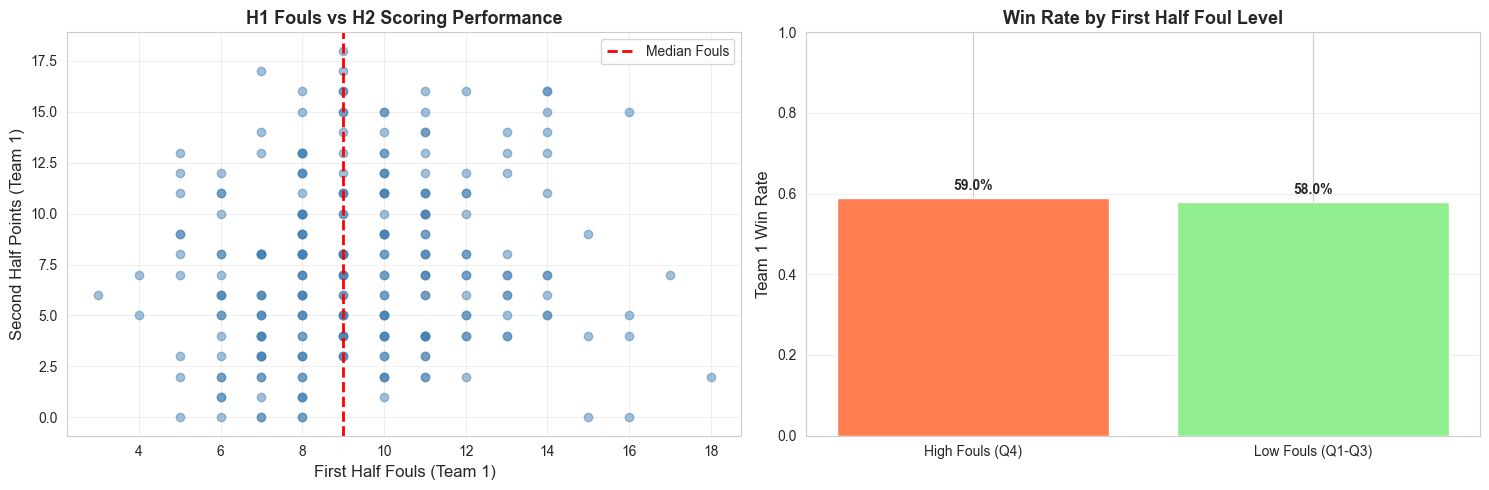

Win rate for Team1 with HIGH fouls in H1: 58.97%
Win rate for Team1 with LOW fouls in H1: 58.01%
Difference: -0.96%

[HYPOTHESIS 2] Offensive Rebounds vs Winning


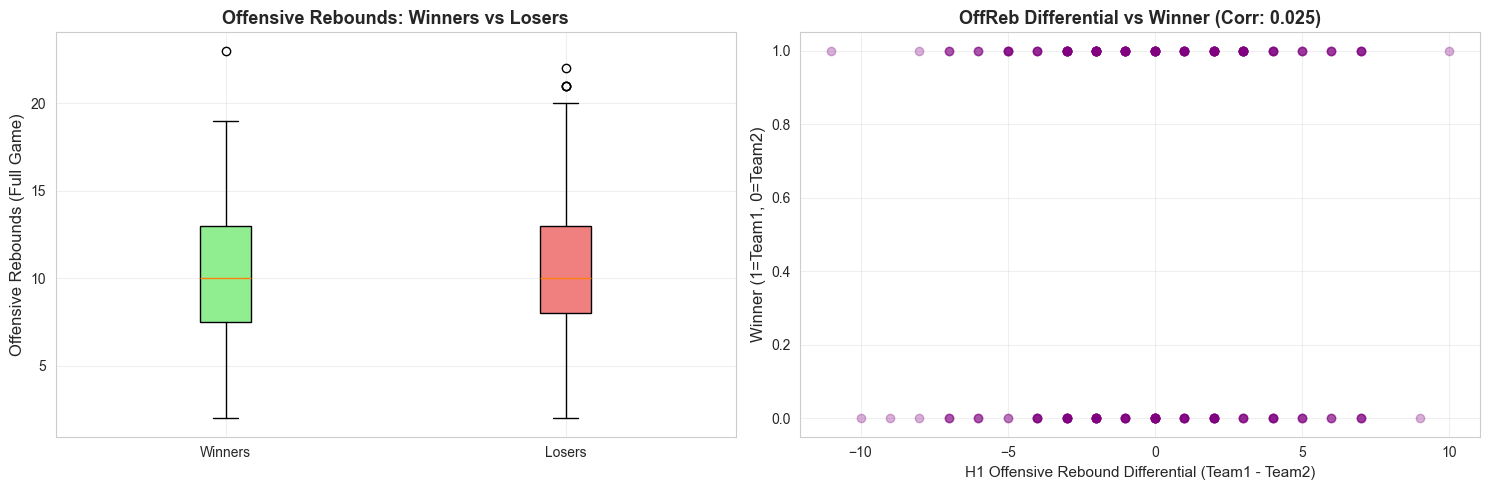

Average Offensive Rebounds - Winners: 10.33
Average Offensive Rebounds - Losers: 10.50
Correlation (H1 OffReb Diff vs Winner): 0.025

[HYPOTHESIS 3] Steal Consistency Between Halves


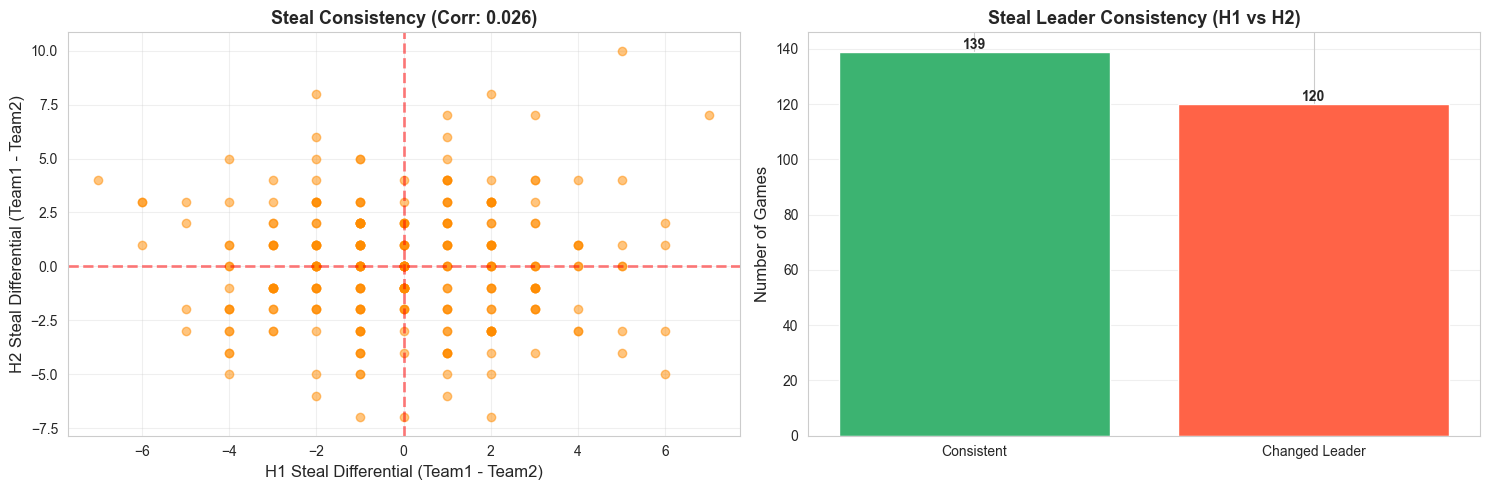

Steal leader consistency rate: 53.67%
Correlation (H1 vs H2 Steal Differential): 0.026

[HYPOTHESIS 4] Comeback Analysis


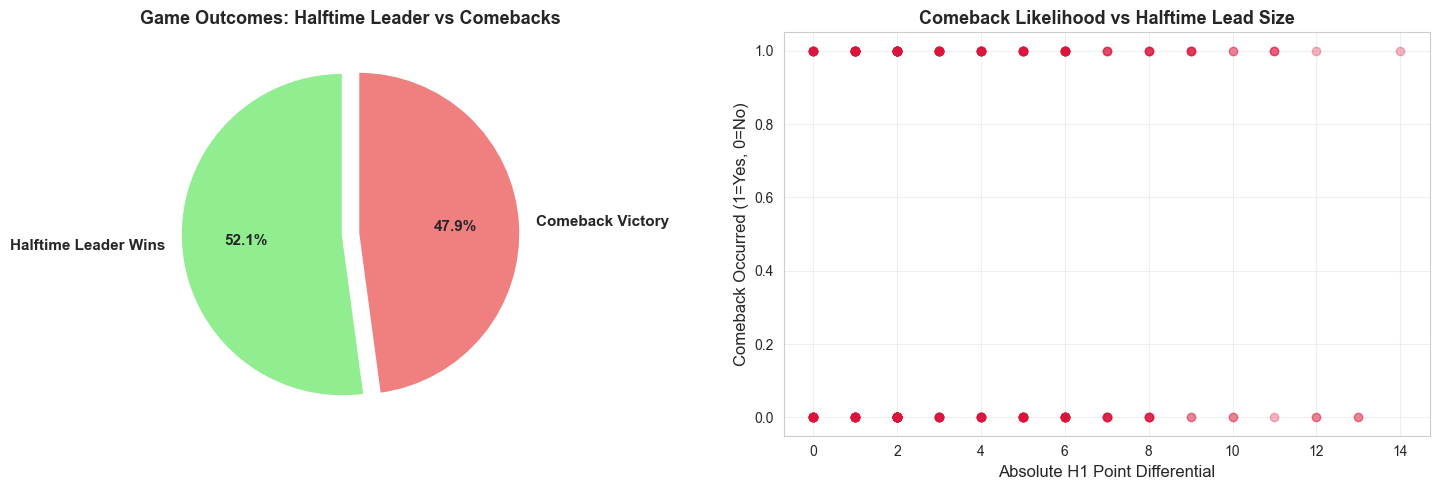

Total games: 259
Halftime leader wins: 135 (52.12%)
Comeback victories: 124 (47.88%)


In [10]:
# ============================================================================
# PART 2: HYPOTHESIS TESTING & VISUALIZATIONS
# ============================================================================
print("\n" + "=" * 80)
print("PART 2: HYPOTHESIS TESTING")
print("=" * 80)

# ----------------------------------------------------------------------------
# HYPOTHESIS 1: Do teams with too many fouls in H1 perform worse in H2?
# ----------------------------------------------------------------------------
print("\n[HYPOTHESIS 1] Foul Impact on Second Half Performance")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Team1 analysis
df_games['H2_Points_Improvement_T1'] = df_games['H2_Points_Team1'] - df_games['H1_Points_Team1']
axes[0].scatter(df_games['H1_Team1_Fouls'], df_games['H2_Points_Team1'], alpha=0.5, color='steelblue')
axes[0].set_xlabel('First Half Fouls (Team 1)', fontsize=12)
axes[0].set_ylabel('Second Half Points (Team 1)', fontsize=12)
axes[0].set_title('H1 Fouls vs H2 Scoring Performance', fontsize=13, fontweight='bold')
axes[0].axvline(df_games['H1_Team1_Fouls'].median(), color='red', linestyle='--', label='Median Fouls', linewidth=2)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# High foul teams vs low foul teams win rate
high_foul_threshold = df_games['H1_Team1_Fouls'].quantile(0.75)
df_games['T1_High_Fouls'] = df_games['H1_Team1_Fouls'] >= high_foul_threshold
win_rate_high_fouls = df_games[df_games['T1_High_Fouls'] == True]['Winner'].mean()
win_rate_low_fouls = df_games[df_games['T1_High_Fouls'] == False]['Winner'].mean()

axes[1].bar(['High Fouls (Q4)', 'Low Fouls (Q1-Q3)'], [win_rate_high_fouls, win_rate_low_fouls], 
            color=['coral', 'lightgreen'])
axes[1].set_ylabel('Team 1 Win Rate', fontsize=12)
axes[1].set_title('Win Rate by First Half Foul Level', fontsize=13, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, v in enumerate([win_rate_high_fouls, win_rate_low_fouls]):
    axes[1].text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('hypothesis1_fouls_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Win rate for Team1 with HIGH fouls in H1: {win_rate_high_fouls:.2%}")
print(f"Win rate for Team1 with LOW fouls in H1: {win_rate_low_fouls:.2%}")
print(f"Difference: {(win_rate_low_fouls - win_rate_high_fouls):.2%}")

# ----------------------------------------------------------------------------
# HYPOTHESIS 2: Correlation between Offensive Rebounds and Winning
# ----------------------------------------------------------------------------
print("\n[HYPOTHESIS 2] Offensive Rebounds vs Winning")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot: Winner vs Loser offensive rebounds
winners_offreb = df_games.apply(lambda x: x['Full_OffReb_Team1'] if x['Winner'] == 1 else x['Full_OffReb_Team2'], axis=1)
losers_offreb = df_games.apply(lambda x: x['Full_OffReb_Team2'] if x['Winner'] == 1 else x['Full_OffReb_Team1'], axis=1)

box_data = [winners_offreb, losers_offreb]
bp = axes[0].boxplot(box_data, labels=['Winners', 'Losers'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightgreen', 'lightcoral']):
    patch.set_facecolor(color)
axes[0].set_ylabel('Offensive Rebounds (Full Game)', fontsize=12)
axes[0].set_title('Offensive Rebounds: Winners vs Losers', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Correlation between OffReb differential and winning
corr_offreb = df_games['H1_OffReb_Diff'].corr(df_games['Winner'])
axes[1].scatter(df_games['H1_OffReb_Diff'], df_games['Winner'], alpha=0.3, color='purple')
axes[1].set_xlabel('H1 Offensive Rebound Differential (Team1 - Team2)', fontsize=11)
axes[1].set_ylabel('Winner (1=Team1, 0=Team2)', fontsize=12)
axes[1].set_title(f'OffReb Differential vs Winner (Corr: {corr_offreb:.3f})', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hypothesis2_rebounds.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Average Offensive Rebounds - Winners: {winners_offreb.mean():.2f}")
print(f"Average Offensive Rebounds - Losers: {losers_offreb.mean():.2f}")
print(f"Correlation (H1 OffReb Diff vs Winner): {corr_offreb:.3f}")

# ----------------------------------------------------------------------------
# HYPOTHESIS 3: Steal Consistency between Halves
# ----------------------------------------------------------------------------
print("\n[HYPOTHESIS 3] Steal Consistency Between Halves")

# Calculate H2 steals differential
df_games['H2_Steals_Diff'] = (df_games['Full_Steals_Team1'] - df_games['Full_Steals_Team2']) - df_games['H1_Steals_Diff']

# Calculate who leads in steals per half
df_games['H1_Steal_Leader'] = (df_games['H1_Steals_Diff'] > 0).astype(int)
df_games['H2_Steal_Leader'] = (df_games['H2_Steals_Diff'] > 0).astype(int)

consistency_rate = (df_games['H1_Steal_Leader'] == df_games['H2_Steal_Leader']).mean()
corr_steals = df_games['H1_Steals_Diff'].corr(df_games['H2_Steals_Diff'])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(df_games['H1_Steals_Diff'], df_games['H2_Steals_Diff'], alpha=0.5, color='darkorange')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5, linewidth=2)
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=2)
axes[0].set_xlabel('H1 Steal Differential (Team1 - Team2)', fontsize=12)
axes[0].set_ylabel('H2 Steal Differential (Team1 - Team2)', fontsize=12)
axes[0].set_title(f'Steal Consistency (Corr: {corr_steals:.3f})', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Consistency bar chart
consistency_count = (df_games['H1_Steal_Leader'] == df_games['H2_Steal_Leader']).sum()
inconsistency_count = len(df_games) - consistency_count
bars = axes[1].bar(['Consistent', 'Changed Leader'], [consistency_count, inconsistency_count],
                    color=['mediumseagreen', 'tomato'])
axes[1].set_ylabel('Number of Games', fontsize=12)
axes[1].set_title('Steal Leader Consistency (H1 vs H2)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('hypothesis3_steals.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Steal leader consistency rate: {consistency_rate:.2%}")
print(f"Correlation (H1 vs H2 Steal Differential): {corr_steals:.3f}")

# ----------------------------------------------------------------------------
# HYPOTHESIS 4: Comeback Analysis (Half-time leader loses)
# ----------------------------------------------------------------------------
print("\n[HYPOTHESIS 4] Comeback Analysis")

# How often does the halftime leader lose?
comeback_rate = (df_games['H1_Leader'] != df_games['Winner']).mean()
halftime_leader_wins = (df_games['H1_Leader'] == df_games['Winner']).sum()
comebacks = len(df_games) - halftime_leader_wins

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart
colors = ['lightgreen', 'lightcoral']
explode = (0.05, 0.05)
axes[0].pie([halftime_leader_wins, comebacks], 
            labels=['Halftime Leader Wins', 'Comeback Victory'], 
            autopct='%1.1f%%', startangle=90, colors=colors, explode=explode,
            textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[0].set_title('Game Outcomes: Halftime Leader vs Comebacks', fontsize=13, fontweight='bold')

# Point differential analysis
df_games['Comeback'] = (df_games['H1_Leader'] != df_games['Winner']).astype(int)
axes[1].scatter(df_games['H1_Points_Diff'].abs(), df_games['Comeback'], alpha=0.3, color='crimson')
axes[1].set_xlabel('Absolute H1 Point Differential', fontsize=12)
axes[1].set_ylabel('Comeback Occurred (1=Yes, 0=No)', fontsize=12)
axes[1].set_title('Comeback Likelihood vs Halftime Lead Size', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hypothesis4_comebacks.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Total games: {len(df_games)}")
print(f"Halftime leader wins: {halftime_leader_wins} ({(1-comeback_rate):.2%})")
print(f"Comeback victories: {comebacks} ({comeback_rate:.2%})")


PART 3: MACHINE LEARNING PREDICTIONS

TARGET: Game Winner
Training set: 194 games
Test set: 65 games

[Decision Tree]
Accuracy: 0.5846 (58.46%)

[XGBoost]
Accuracy: 0.4615 (46.15%)

[Feature Importance - XGBoost]
       Feature  Importance
H1_Steals_Diff    0.278785
 H1_Fouls_Diff    0.277993
H1_OffReb_Diff    0.230563
H1_Points_Diff    0.212659

TARGET: Offensive Rebound Winner
Training set: 194 games
Test set: 65 games

[Decision Tree]
Accuracy: 0.7385 (73.85%)

[XGBoost]
Accuracy: 0.7692 (76.92%)

[Feature Importance - XGBoost]
       Feature  Importance
H1_OffReb_Diff    0.591272
H1_Steals_Diff    0.157997
H1_Points_Diff    0.130104
 H1_Fouls_Diff    0.120628

TARGET: Steals Winner
Training set: 194 games
Test set: 65 games

[Decision Tree]
Accuracy: 0.7077 (70.77%)

[XGBoost]
Accuracy: 0.7231 (72.31%)

[Feature Importance - XGBoost]
       Feature  Importance
H1_Steals_Diff    0.567848
H1_Points_Diff    0.152911
 H1_Fouls_Diff    0.144488
H1_OffReb_Diff    0.134753

[STEP 5] Gene

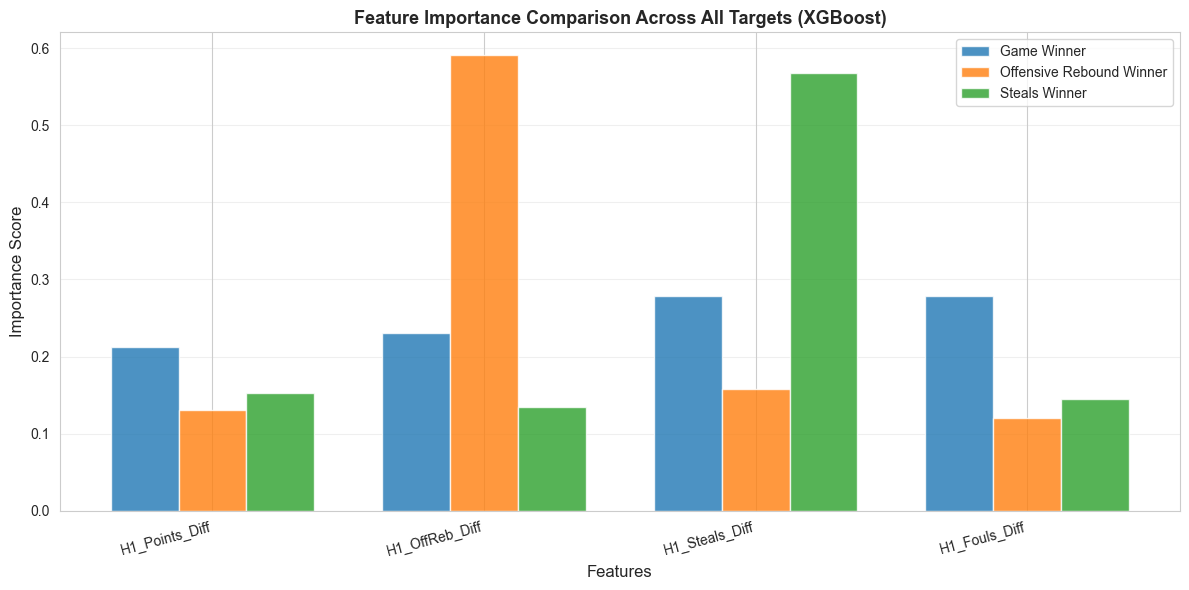

In [11]:
# ============================================================================
# PART 3: PREDICTIVE MODELING
# ============================================================================
print("\n" + "=" * 80)
print("PART 3: MACHINE LEARNING PREDICTIONS")
print("=" * 80)

# Features: Only First Half (H1) statistics
feature_cols = ['H1_Points_Diff', 'H1_OffReb_Diff', 'H1_Steals_Diff', 'H1_Fouls_Diff']
X = df_games[feature_cols]

# Three targets
targets = {
    'Game Winner': 'Winner',
    'Offensive Rebound Winner': 'OffReb_Winner',
    'Steals Winner': 'Steals_Winner'
}

results = []
feature_importance_data = []

for target_name, target_col in targets.items():
    print(f"\n{'=' * 60}")
    print(f"TARGET: {target_name}")
    print(f"{'=' * 60}")
    
    y = df_games[target_col]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    print(f"Training set: {len(X_train)} games")
    print(f"Test set: {len(X_test)} games")
    
    # -----------------------------------------------------------------------
    # Model 1: Decision Tree
    # -----------------------------------------------------------------------
    dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt_model.fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)
    dt_acc = accuracy_score(y_test, dt_pred)
    
    print(f"\n[Decision Tree]")
    print(f"Accuracy: {dt_acc:.4f} ({dt_acc*100:.2f}%)")
    
    # -----------------------------------------------------------------------
    # Model 2: XGBoost
    # -----------------------------------------------------------------------
    xgb_model = XGBClassifier(max_depth=4, n_estimators=100, random_state=42, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    xgb_acc = accuracy_score(y_test, xgb_pred)
    
    print(f"\n[XGBoost]")
    print(f"Accuracy: {xgb_acc:.4f} ({xgb_acc*100:.2f}%)")
    
    # Feature Importance
    print(f"\n[Feature Importance - XGBoost]")
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    print(importance_df.to_string(index=False))
    
    # Store feature importance for visualization
    for _, row in importance_df.iterrows():
        feature_importance_data.append({
            'Target': target_name,
            'Feature': row['Feature'],
            'Importance': row['Importance']
        })
    
    results.append({
        'Target': target_name,
        'DT_Accuracy': dt_acc,
        'XGB_Accuracy': xgb_acc,
        'Best_Model': 'XGBoost' if xgb_acc > dt_acc else 'Decision Tree'
    })

# ============================================================================
# VISUALIZE FEATURE IMPORTANCE
# ============================================================================
print("\n[STEP 5] Generating Feature Importance Visualization...")

fi_df = pd.DataFrame(feature_importance_data)

fig, ax = plt.subplots(figsize=(12, 6))
targets_list = fi_df['Target'].unique()
x = np.arange(len(feature_cols))
width = 0.25

for i, target in enumerate(targets_list):
    target_data = fi_df[fi_df['Target'] == target].set_index('Feature')
    values = [target_data.loc[feat, 'Importance'] if feat in target_data.index else 0 for feat in feature_cols]
    ax.bar(x + i*width, values, width, label=target, alpha=0.8)

ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Importance Score', fontsize=12)
ax.set_title('Feature Importance Comparison Across All Targets (XGBoost)', fontsize=13, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(feature_cols, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("FINAL RESULTS SUMMARY")
print("=" * 80)

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)

#we want to look each team performance in each hypothesis and summarize the key insights

# Find best overall predictor
overall_best = results_df.loc[results_df['XGB_Accuracy'].idxmax()]
print(f"\nBest Prediction Target: {overall_best['Target']}")
print(f"  → XGBoost Accuracy: {overall_best['XGB_Accuracy']:.2%}")

# Most important feature overall
top_feature = fi_df.groupby('Feature')['Importance'].mean().idxmax()
top_importance = fi_df.groupby('Feature')['Importance'].mean().max()
print(f"\nMost Important H1 Feature (Overall): {top_feature}")
print(f"  → Average Importance: {top_importance:.3f}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print("\nGenerated Visualizations:")
print("  1. hypothesis1_fouls_impact.png - Foul analysis")
print("  2. hypothesis2_rebounds.png - Offensive rebound impact")
print("  3. hypothesis3_steals.png - Steal consistency")
print("  4. hypothesis4_comebacks.png - Comeback analysis")
print("  5. feature_importance.png - ML feature importance")
print("\nAll results based on 2020-2021 season data only!")
print("=" * 80)


FINAL RESULTS SUMMARY

                  Target  DT_Accuracy  XGB_Accuracy    Best_Model
             Game Winner     0.584615      0.461538 Decision Tree
Offensive Rebound Winner     0.738462      0.769231       XGBoost
           Steals Winner     0.707692      0.723077       XGBoost

KEY INSIGHTS

Best Prediction Target: Offensive Rebound Winner
  → XGBoost Accuracy: 76.92%

Most Important H1 Feature (Overall): H1_Steals_Diff
  → Average Importance: 0.335

ANALYSIS COMPLETE!

Generated Visualizations:
  1. hypothesis1_fouls_impact.png - Foul analysis
  2. hypothesis2_rebounds.png - Offensive rebound impact
  3. hypothesis3_steals.png - Steal consistency
  4. hypothesis4_comebacks.png - Comeback analysis
  5. feature_importance.png - ML feature importance

All results based on 2020-2021 season data only!


Decision Tree Modeli Eğitiliyor ve Çiziliyor...


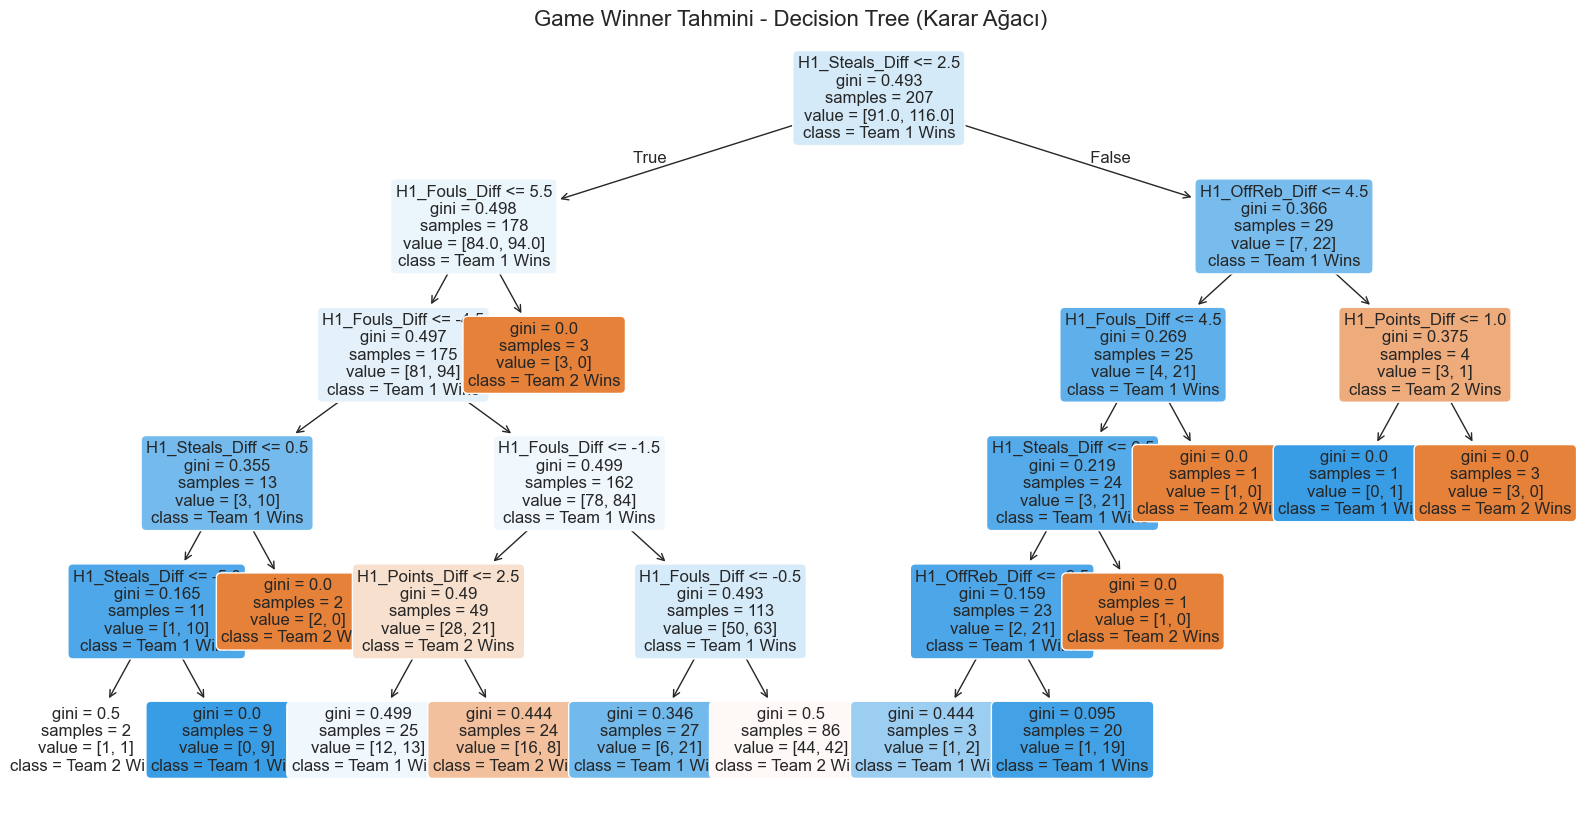

XGBoost Modeli Eğitiliyor ve Grafikleri Çiziliyor...


<Figure size 1000x600 with 0 Axes>

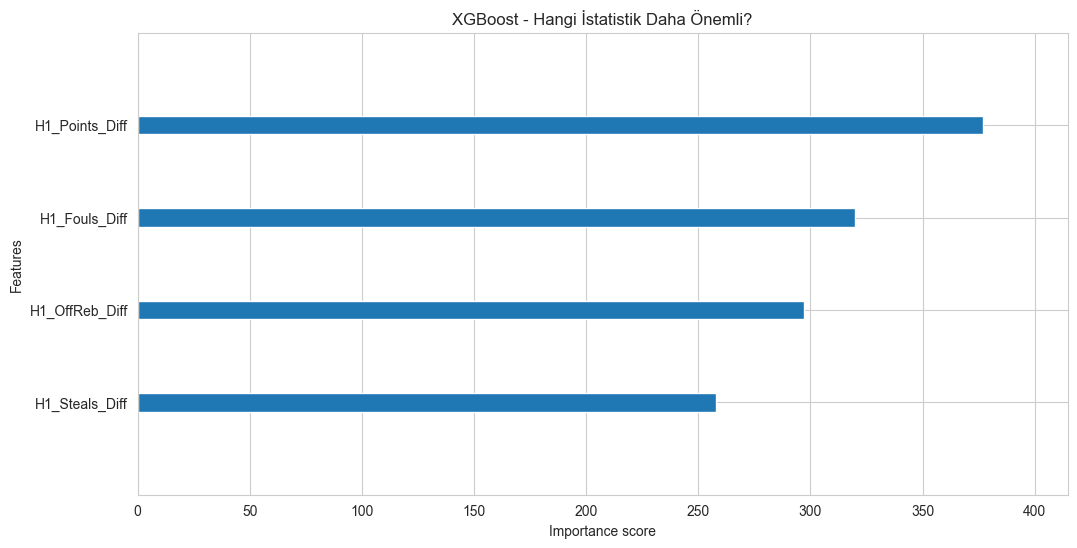

ImportError: You must install graphviz to plot tree

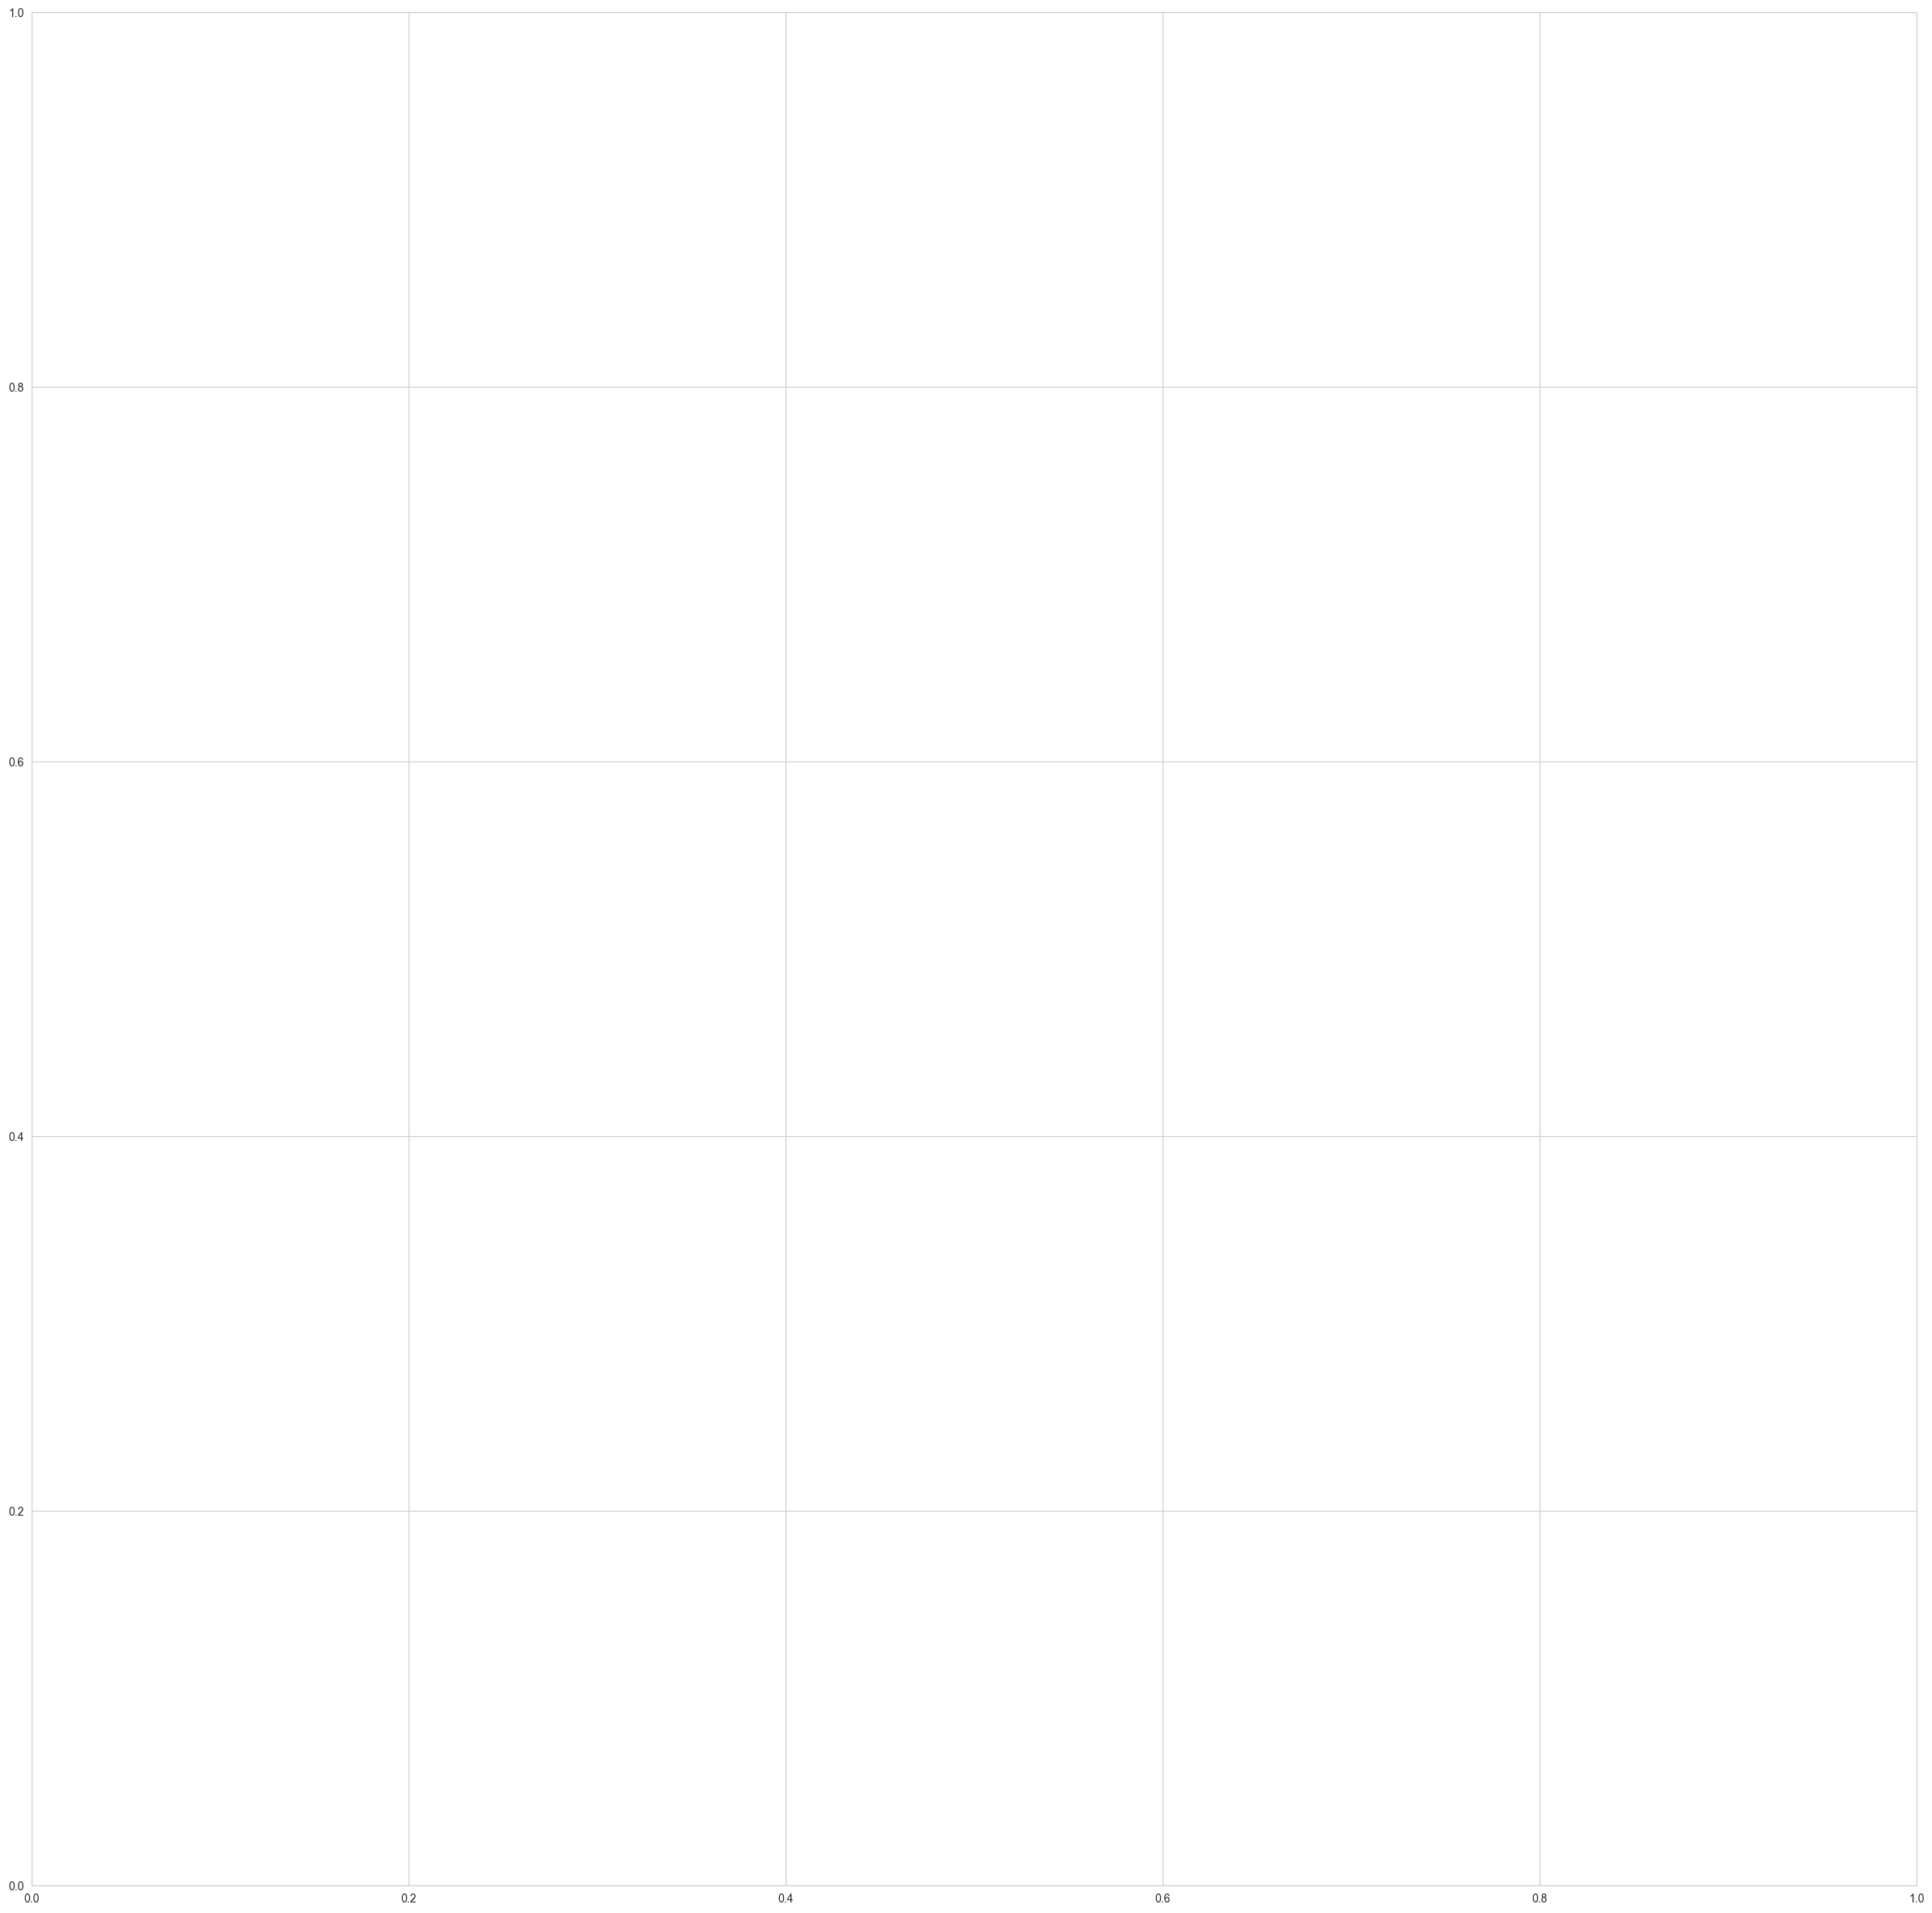

In [15]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier, plot_importance, plot_tree as xgb_plot_tree
from sklearn.model_selection import train_test_split

# ======================================================
# 1. VERİ HAZIRLIĞI (Notebook'unuzdaki mantığa göre)
# ======================================================
# Eğer df_games zaten hafızadaysa bu adımı atlayabilirsiniz.
# Değilse, notebook'unuzdaki [STEP 4] kısmını çalıştırdığınızdan emin olun.

# Tahmin için kullanılacak özellikler (Notebook mantığına göre farklar önemlidir)
# Genellikle kazananı tahmin etmek için ilk yarı farkları kullanılır.
feature_cols = [
    'H1_Points_Diff',   # İlk yarı puan farkı
    'H1_OffReb_Diff',   # İlk yarı ofansif ribaund farkı
    'H1_Steals_Diff',   # İlk yarı top çalma farkı
    'H1_Fouls_Diff'     # İlk yarı faul farkı
]

# Hedef değişken (1: Takım 1 kazanır, 0: Takım 2 kazanır)
target_col = 'Winner'

# Veriyi X ve y olarak ayırma
X = df_games[feature_cols]
y = df_games[target_col]

# Eğitim ve test seti olarak ayırma (%80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ======================================================
# 2. DECISION TREE (KARAR AĞACI) GÖRSELLEŞTİRME
# ======================================================
print("Decision Tree Modeli Eğitiliyor ve Çiziliyor...")

# Modeli Eğitme (Görselin okunabilir olması için derinliği 5 ile sınırlandırdık)
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Grafiği Çizme
plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          feature_names=feature_cols,  
          class_names=['Team 2 Wins', 'Team 1 Wins'],
          filled=True, 
          rounded=True, 
          fontsize=12)
plt.title("Game Winner Tahmini - Decision Tree (Karar Ağacı)", fontsize=16)
plt.show()

# ======================================================
# 3. XGBOOST GÖRSELLEŞTİRME
# ======================================================
print("XGBoost Modeli Eğitiliyor ve Grafikleri Çiziliyor...")

# XGBoost Modelini Eğitme
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)

# --- Grafik 3.1: Özellik Önem Düzeyi (Feature Importance) ---
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='weight', title='XGBoost - Hangi İstatistik Daha Önemli?', show_values=False)
plt.show()

# --- Grafik 3.2: Örnek Bir XGBoost Ağacı ---
# XGBoost yüzlerce ağaçtan oluşur, burada sadece ilkini çiziyoruz (num_trees=0)
fig, ax = plt.subplots(figsize=(30, 30))
xgb_plot_tree(xgb_model, num_trees=0, ax=ax)
plt.title("XGBoost - Örnek Karar Ağacı (İlk Ağaç)", fontsize=20)
plt.show()

In [ ]:
# ============================================================================
# LOAD THE PROCESSED DATA (from previous script)
# ============================================================================
print("\n[STEP 1] Loading and Preparing Data...")

# You need to run the previous script first to get df_games
# For standalone execution, we'll recreate the essential parts
actions_df = robust_read_csv('actions_3_seasons.csv')
actions_df = actions_df[actions_df['Years'] == '2020-2021'].copy()

print(f"Loaded {len(actions_df)} actions from 2020-2021 season")

# Quick aggregation function
def aggregate_team_stats(df, match_id, team_id, periods):
    mask = (df['matchId'] == match_id) & (df['teamId'] == team_id) & (df['period'].isin(periods))
    team_data = df[mask]
    
    stats = {
        'points': 0,
        'off_rebounds': 0,
        'steals': 0,
        'fouls': 0
    }
    
    made_2pt = len(team_data[(team_data['actionType'] == 'twopoint') & (team_data['success'] == 1)])
    made_3pt = len(team_data[(team_data['actionType'] == 'threepoint') & (team_data['success'] == 1)])
    made_ft = len(team_data[(team_data['actionType'] == 'freethrow') & (team_data['success'] == 1)])
    stats['points'] = (made_2pt * 2) + (made_3pt * 3) + made_ft
    stats['off_rebounds'] = len(team_data[(team_data['actionType'] == 'rebound') & (team_data['subType'] == 'offensive')])
    stats['steals'] = len(team_data[team_data['actionType'] == 'steal'])
    stats['fouls'] = len(team_data[team_data['actionType'] == 'foul'])
    
    return stats

# Extract game results
game_results = []
for match_id in actions_df['matchId'].unique():
    match_data = actions_df[actions_df['matchId'] == match_id].copy()
    final_scores = match_data[['score1', 'score2']].dropna()
    
    if not final_scores.empty:
        final_score = final_scores.tail(1)
        teams = match_data['teamId'].dropna().unique()
        if len(teams) >= 2:
            game_results.append({
                'matchId': match_id,
                'team1_id': teams[0],
                'team2_id': teams[1],
                'team1_final': final_score['score1'].values[0],
                'team2_final': final_score['score2'].values[0]
            })

game_results_df = pd.DataFrame(game_results)

# Build dataset
game_data = []
for _, game in game_results_df.iterrows():
    match_id = game['matchId']
    team1_id = game['team1_id']
    team2_id = game['team2_id']
    
    t1_h1 = aggregate_team_stats(actions_df, match_id, team1_id, [1, 2])
    t2_h1 = aggregate_team_stats(actions_df, match_id, team2_id, [1, 2])
    t1_h2 = aggregate_team_stats(actions_df, match_id, team1_id, [3, 4])
    t2_h2 = aggregate_team_stats(actions_df, match_id, team2_id, [3, 4])
    
    t1_full = {k: t1_h1[k] + t1_h2[k] for k in t1_h1.keys()}
    t2_full = {k: t2_h1[k] + t2_h2[k] for k in t2_h1.keys()}
    
    winner = 1 if game['team1_final'] > game['team2_final'] else 0
    
    game_data.append({
        'matchId': match_id,
        # H1 differentials
        'H1_Points_Diff': t1_h1['points'] - t2_h1['points'],
        'H1_OffReb_Diff': t1_h1['off_rebounds'] - t2_h1['off_rebounds'],
        'H1_Steals_Diff': t1_h1['steals'] - t2_h1['steals'],
        'H1_Fouls_Diff': t1_h1['fouls'] - t2_h1['fouls'],
        # H1 individual team stats
        'H1_OffReb_Team1': t1_h1['off_rebounds'],
        'H1_OffReb_Team2': t2_h1['off_rebounds'],
        'H1_Steals_Team1': t1_h1['steals'],
        'H1_Steals_Team2': t2_h1['steals'],
        'H1_Points_Team1': t1_h1['points'],
        'H1_Points_Team2': t2_h1['points'],
        # H2 individual team stats
        'H2_Points_Team1': t1_h2['points'],
        'H2_Points_Team2': t2_h2['points'],
        # Full game stats
        'Full_OffReb_Team1': t1_full['off_rebounds'],
        'Full_OffReb_Team2': t2_full['off_rebounds'],
        'Full_Steals_Team1': t1_full['steals'],
        'Full_Steals_Team2': t2_full['steals'],
        # Targets
        'Winner': winner,
        'OffReb_Winner': 1 if t1_full['off_rebounds'] > t2_full['off_rebounds'] else 0,
        'Steals_Winner': 1 if t1_full['steals'] > t2_full['steals'] else 0,
        'H1_Leader': 1 if t1_h1['points'] > t2_h1['points'] else 0,
    })

df_games = pd.DataFrame(game_data)
print(f"Processed {len(df_games)} complete games")


[STEP 1] Loading and Preparing Data...
Loaded 180161 actions from 2020-2021 season
Processed 259 complete games



PATTERN 1: H1 Offensive Rebound Leader → Game Winner

H1 Offensive Rebound Leader Wins Game: 130/259 (50.19%)
H1 Offensive Rebound Leader Loses Game: 129 (49.81%)

Chi-Square Test: χ² = 0.1900, p-value = 0.6629
Result: NOT significant (p ≥ 0.05)


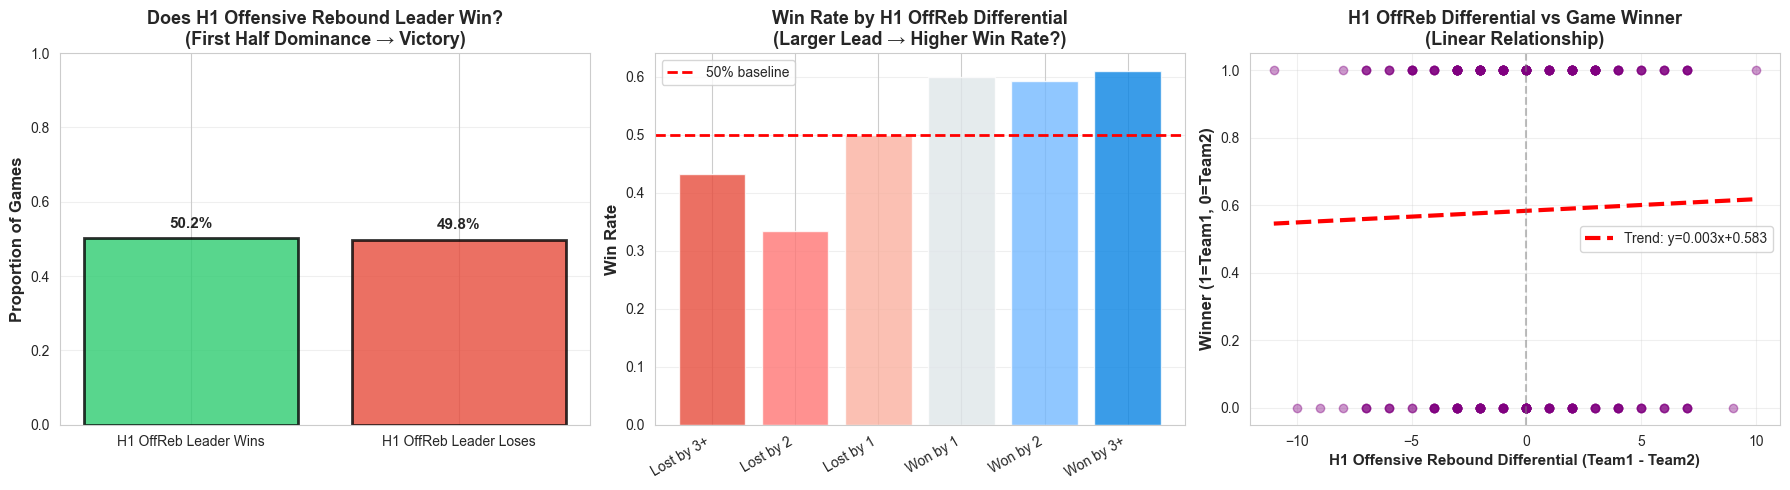

In [ ]:
from scipy import stats

# ============================================================================
# PATTERN ANALYSIS 1: Offensive Rebounds Leading in H1 → Game Winner
# ============================================================================
print("\n" + "=" * 80)
print("PATTERN 1: H1 Offensive Rebound Leader → Game Winner")
print("=" * 80)

# Who has more offensive rebounds in H1?
df_games['H1_OffReb_Leader'] = (df_games['H1_OffReb_Diff'] > 0).astype(int)  # 1 = Team1, 0 = Team2

# Calculate win rate for H1 offensive rebound leaders
offreb_leader_wins = (df_games['H1_OffReb_Leader'] == df_games['Winner']).sum()
offreb_leader_win_rate = (df_games['H1_OffReb_Leader'] == df_games['Winner']).mean()

print(f"\nH1 Offensive Rebound Leader Wins Game: {offreb_leader_wins}/{len(df_games)} ({offreb_leader_win_rate:.2%})")
print(f"H1 Offensive Rebound Leader Loses Game: {len(df_games) - offreb_leader_wins} ({1-offreb_leader_win_rate:.2%})")

# Statistical significance test
contingency_table = pd.crosstab(df_games['H1_OffReb_Leader'], df_games['Winner'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\nChi-Square Test: χ² = {chi2:.4f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("Result: SIGNIFICANT relationship (p < 0.05)")
else:
    print("Result: NOT significant (p ≥ 0.05)")

# Visualization 1: Win Rate by H1 OffReb Leadership
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Chart 1: Simple win rate comparison
categories = ['H1 OffReb Leader Wins', 'H1 OffReb Leader Loses']
values = [offreb_leader_win_rate, 1 - offreb_leader_win_rate]
colors = ['#2ecc71', '#e74c3c']
bars1 = axes[0].bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Proportion of Games', fontsize=12, fontweight='bold')
axes[0].set_title('Does H1 Offensive Rebound Leader Win?\n(First Half Dominance → Victory)', 
                   fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Chart 2: Breakdown by offensive rebound differential magnitude
df_games['H1_OffReb_Diff_Cat'] = pd.cut(df_games['H1_OffReb_Diff'], 
                                         bins=[-np.inf, -2, -1, 0, 1, 2, np.inf],
                                         labels=['Lost by 3+', 'Lost by 2', 'Lost by 1', 'Won by 1', 'Won by 2', 'Won by 3+'])
win_by_offreb_cat = df_games.groupby('H1_OffReb_Diff_Cat')['Winner'].apply(
    lambda x: (x == 1).mean() if ((df_games.loc[x.index, 'H1_OffReb_Diff'] > 0).all() or 
                                   (df_games.loc[x.index, 'H1_OffReb_Diff'] == 0).all()) 
           else (x == 0).mean()
)
axes[1].bar(range(len(win_by_offreb_cat)), win_by_offreb_cat.values, 
            color=['#e74c3c', '#ff7675', '#fab1a0', '#dfe6e9', '#74b9ff', '#0984e3'], alpha=0.8)
axes[1].set_xticks(range(len(win_by_offreb_cat)))
axes[1].set_xticklabels(win_by_offreb_cat.index, rotation=30, ha='right')
axes[1].set_ylabel('Win Rate', fontsize=12, fontweight='bold')
axes[1].set_title('Win Rate by H1 OffReb Differential\n(Larger Lead → Higher Win Rate?)', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(0.5, color='red', linestyle='--', linewidth=2, label='50% baseline')
axes[1].legend()

# Chart 3: Scatter plot with trend
axes[2].scatter(df_games['H1_OffReb_Diff'], df_games['Winner'], alpha=0.4, color='purple')
z = np.polyfit(df_games['H1_OffReb_Diff'], df_games['Winner'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df_games['H1_OffReb_Diff'].min(), df_games['H1_OffReb_Diff'].max(), 100)
axes[2].plot(x_trend, p(x_trend), "r--", linewidth=3, label=f'Trend: y={z[0]:.3f}x+{z[1]:.3f}')
axes[2].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[2].set_xlabel('H1 Offensive Rebound Differential (Team1 - Team2)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Winner (1=Team1, 0=Team2)', fontsize=12, fontweight='bold')
axes[2].set_title('H1 OffReb Differential vs Game Winner\n(Linear Relationship)', 
                  fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pattern1_offreb_leader_wins.png', dpi=300, bbox_inches='tight')
plt.show()



PATTERN 2: H1 Steal Leader → Game Winner

H1 Steal Leader Wins Game: 129/259 (49.81%)
H1 Steal Leader Loses Game: 130 (50.19%)

Chi-Square Test: χ² = 0.1086, p-value = 0.7418
Result: NOT significant (p ≥ 0.05)


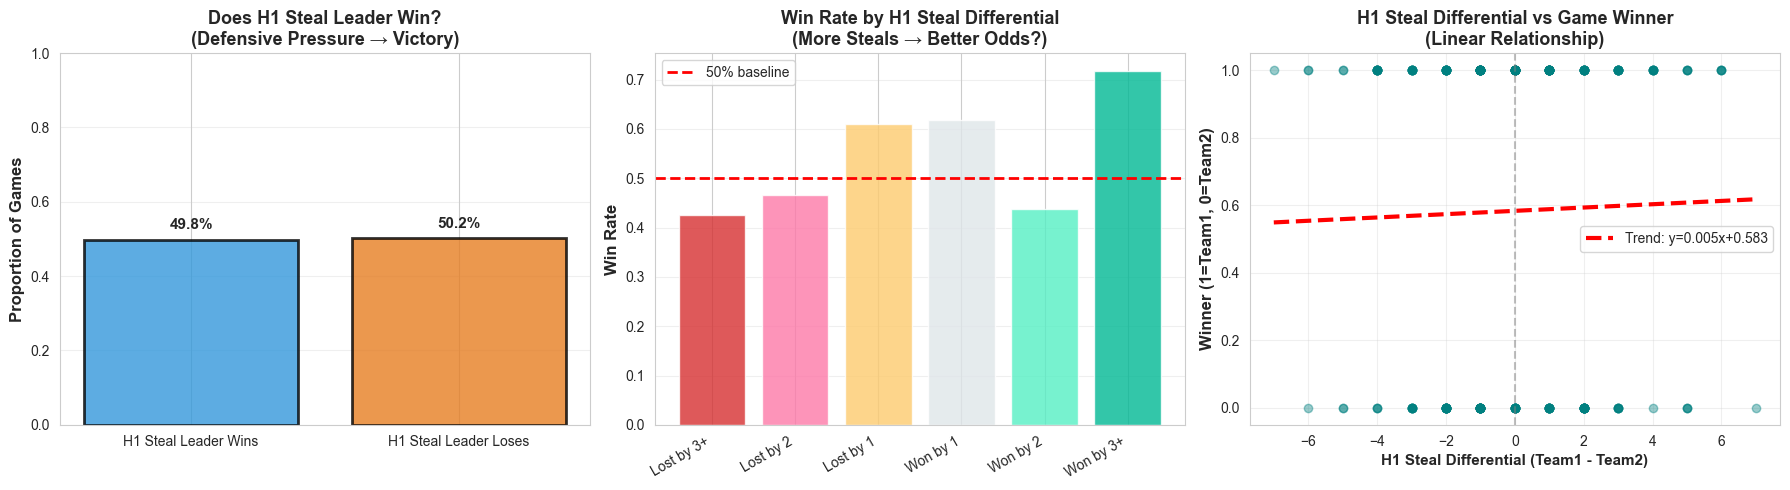

In [ ]:
# ============================================================================
# PATTERN ANALYSIS 2: Steals Leading in H1 → Game Winner
# ============================================================================
print("\n" + "=" * 80)
print("PATTERN 2: H1 Steal Leader → Game Winner")
print("=" * 80)

# Who has more steals in H1?
df_games['H1_Steal_Leader'] = (df_games['H1_Steals_Diff'] > 0).astype(int)  # 1 = Team1, 0 = Team2

# Calculate win rate for H1 steal leaders
steal_leader_wins = (df_games['H1_Steal_Leader'] == df_games['Winner']).sum()
steal_leader_win_rate = (df_games['H1_Steal_Leader'] == df_games['Winner']).mean()

print(f"\nH1 Steal Leader Wins Game: {steal_leader_wins}/{len(df_games)} ({steal_leader_win_rate:.2%})")
print(f"H1 Steal Leader Loses Game: {len(df_games) - steal_leader_wins} ({1-steal_leader_win_rate:.2%})")

# Statistical significance test
contingency_table = pd.crosstab(df_games['H1_Steal_Leader'], df_games['Winner'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\nChi-Square Test: χ² = {chi2:.4f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("Result: SIGNIFICANT relationship (p < 0.05)")
else:
    print("Result: NOT significant (p ≥ 0.05)")

# Visualization 2: Win Rate by H1 Steal Leadership
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Chart 1: Simple win rate comparison
categories = ['H1 Steal Leader Wins', 'H1 Steal Leader Loses']
values = [steal_leader_win_rate, 1 - steal_leader_win_rate]
colors = ['#3498db', '#e67e22']
bars2 = axes[0].bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Proportion of Games', fontsize=12, fontweight='bold')
axes[0].set_title('Does H1 Steal Leader Win?\n(Defensive Pressure → Victory)', 
                   fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for bar in bars2:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Chart 2: Breakdown by steal differential magnitude
df_games['H1_Steals_Diff_Cat'] = pd.cut(df_games['H1_Steals_Diff'], 
                                         bins=[-np.inf, -2, -1, 0, 1, 2, np.inf],
                                         labels=['Lost by 3+', 'Lost by 2', 'Lost by 1', 'Won by 1', 'Won by 2', 'Won by 3+'])
win_by_steal_cat = df_games.groupby('H1_Steals_Diff_Cat')['Winner'].apply(
    lambda x: (x == 1).mean() if ((df_games.loc[x.index, 'H1_Steals_Diff'] > 0).all() or 
                                   (df_games.loc[x.index, 'H1_Steals_Diff'] == 0).all()) 
           else (x == 0).mean()
)
axes[1].bar(range(len(win_by_steal_cat)), win_by_steal_cat.values, 
            color=['#d63031', '#fd79a8', '#fdcb6e', '#dfe6e9', '#55efc4', '#00b894'], alpha=0.8)
axes[1].set_xticks(range(len(win_by_steal_cat)))
axes[1].set_xticklabels(win_by_steal_cat.index, rotation=30, ha='right')
axes[1].set_ylabel('Win Rate', fontsize=12, fontweight='bold')
axes[1].set_title('Win Rate by H1 Steal Differential\n(More Steals → Better Odds?)', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(0.5, color='red', linestyle='--', linewidth=2, label='50% baseline')
axes[1].legend()

# Chart 3: Scatter plot with trend
axes[2].scatter(df_games['H1_Steals_Diff'], df_games['Winner'], alpha=0.4, color='teal')
z = np.polyfit(df_games['H1_Steals_Diff'], df_games['Winner'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df_games['H1_Steals_Diff'].min(), df_games['H1_Steals_Diff'].max(), 100)
axes[2].plot(x_trend, p(x_trend), "r--", linewidth=3, label=f'Trend: y={z[0]:.3f}x+{z[1]:.3f}')
axes[2].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[2].set_xlabel('H1 Steal Differential (Team1 - Team2)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Winner (1=Team1, 0=Team2)', fontsize=12, fontweight='bold')
axes[2].set_title('H1 Steal Differential vs Game Winner\n(Linear Relationship)', 
                  fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pattern2_steal_leader_wins.png', dpi=300, bbox_inches='tight')
plt.show()


PATTERN 3: Combined Metrics Analysis

Win Rate when leading in BOTH H1 OffReb AND H1 Steals: 65.38%
Win Rate when leading in ONLY H1 OffReb: 55.56%
Win Rate when leading in ONLY H1 Steals: 54.72%
Win Rate when leading in NEITHER: 58.00%


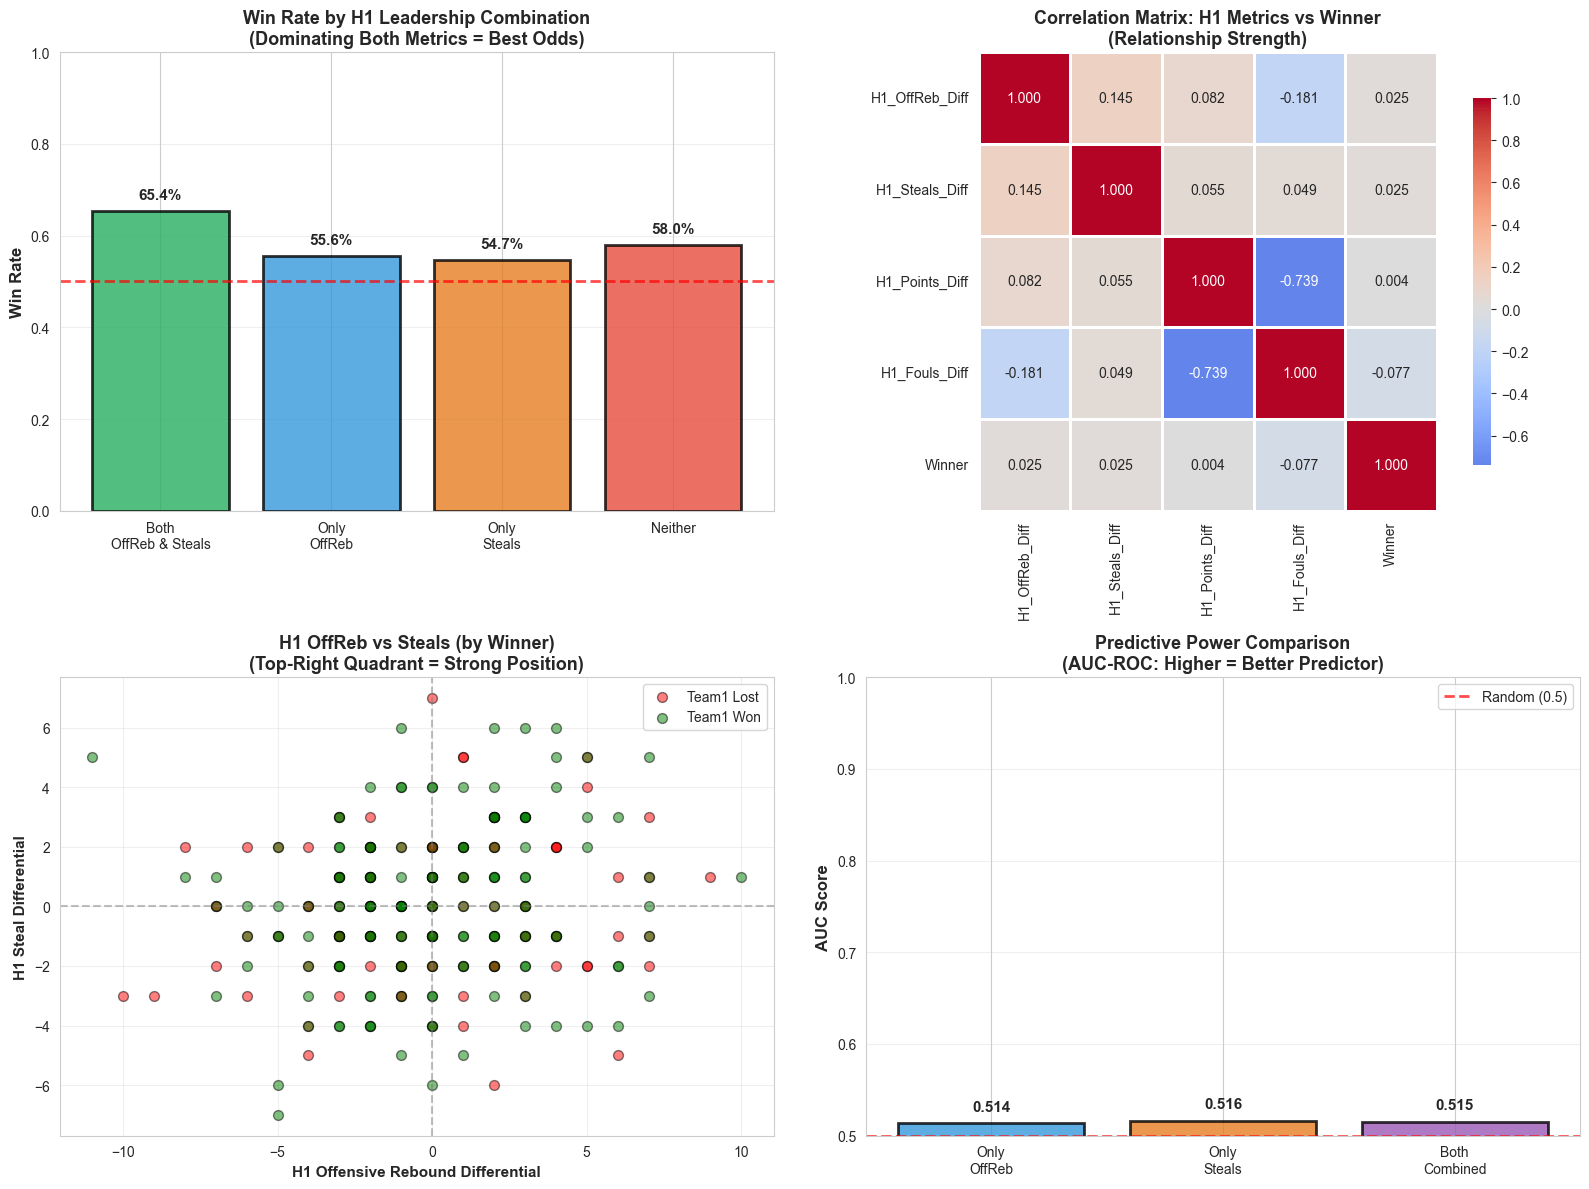


AUC Scores (Predictive Power):
  H1 OffReb Differential alone: 0.5140
  H1 Steal Differential alone: 0.5165
  Both combined: 0.5155


In [ ]:
# ============================================================================
# PATTERN ANALYSIS 3: Combined Metrics Analysis
# ============================================================================
print("\n" + "=" * 80)
print("PATTERN 3: Combined Metrics Analysis")
print("=" * 80)

# Create combined categories
df_games['H1_Both_Leader'] = ((df_games['H1_OffReb_Diff'] > 0) & (df_games['H1_Steals_Diff'] > 0)).astype(int)
df_games['H1_Neither_Leader'] = ((df_games['H1_OffReb_Diff'] <= 0) & (df_games['H1_Steals_Diff'] <= 0)).astype(int)

# Win rates by combined leadership
both_leader_wr = df_games[df_games['H1_Both_Leader'] == 1]['Winner'].mean()
neither_leader_wr = df_games[df_games['H1_Neither_Leader'] == 1]['Winner'].mean()
only_offreb_wr = df_games[(df_games['H1_OffReb_Diff'] > 0) & (df_games['H1_Steals_Diff'] <= 0)]['Winner'].mean()
only_steal_wr = df_games[(df_games['H1_Steals_Diff'] > 0) & (df_games['H1_OffReb_Diff'] <= 0)]['Winner'].mean()

print(f"\nWin Rate when leading in BOTH H1 OffReb AND H1 Steals: {both_leader_wr:.2%}")
print(f"Win Rate when leading in ONLY H1 OffReb: {only_offreb_wr:.2%}")
print(f"Win Rate when leading in ONLY H1 Steals: {only_steal_wr:.2%}")
print(f"Win Rate when leading in NEITHER: {neither_leader_wr:.2%}")

# Visualization 3: Combined analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Win rate by combined leadership status
categories = ['Both\nOffReb & Steals', 'Only\nOffReb', 'Only\nSteals', 'Neither']
values = [both_leader_wr, only_offreb_wr, only_steal_wr, neither_leader_wr]
colors = ['#27ae60', '#3498db', '#e67e22', '#e74c3c']
bars = axes[0, 0].bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0, 0].set_ylabel('Win Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Win Rate by H1 Leadership Combination\n(Dominating Both Metrics = Best Odds)', 
                      fontsize=13, fontweight='bold')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].axhline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[0, 0].grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Chart 2: Correlation heatmap
corr_data = df_games[['H1_OffReb_Diff', 'H1_Steals_Diff', 'H1_Points_Diff', 'H1_Fouls_Diff', 'Winner']].corr()
sns.heatmap(corr_data, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0, 1])
axes[0, 1].set_title('Correlation Matrix: H1 Metrics vs Winner\n(Relationship Strength)', 
                     fontsize=13, fontweight='bold')

# Chart 3: 2D scatter - OffReb vs Steals colored by winner
winners_data = df_games[df_games['Winner'] == 1]
losers_data = df_games[df_games['Winner'] == 0]
axes[1, 0].scatter(losers_data['H1_OffReb_Diff'], losers_data['H1_Steals_Diff'], 
                   alpha=0.5, color='red', s=50, label='Team1 Lost', edgecolors='black')
axes[1, 0].scatter(winners_data['H1_OffReb_Diff'], winners_data['H1_Steals_Diff'], 
                   alpha=0.5, color='green', s=50, label='Team1 Won', edgecolors='black')
axes[1, 0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('H1 Offensive Rebound Differential', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('H1 Steal Differential', fontsize=11, fontweight='bold')
axes[1, 0].set_title('H1 OffReb vs Steals (by Winner)\n(Top-Right Quadrant = Strong Position)', 
                     fontsize=13, fontweight='bold')
axes[1, 0].legend(loc='best', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Chart 4: Comparison of predictive power
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X_offreb = df_games[['H1_OffReb_Diff']].values
X_steals = df_games[['H1_Steals_Diff']].values
X_both = df_games[['H1_OffReb_Diff', 'H1_Steals_Diff']].values
y = df_games['Winner'].values

lr_offreb = LogisticRegression().fit(X_offreb, y)
lr_steals = LogisticRegression().fit(X_steals, y)
lr_both = LogisticRegression().fit(X_both, y)

auc_offreb = roc_auc_score(y, lr_offreb.predict_proba(X_offreb)[:, 1])
auc_steals = roc_auc_score(y, lr_steals.predict_proba(X_steals)[:, 1])
auc_both = roc_auc_score(y, lr_both.predict_proba(X_both)[:, 1])

categories = ['Only\nOffReb', 'Only\nSteals', 'Both\nCombined']
auc_values = [auc_offreb, auc_steals, auc_both]
colors = ['#3498db', '#e67e22', '#9b59b6']
bars = axes[1, 1].bar(categories, auc_values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('AUC Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Predictive Power Comparison\n(AUC-ROC: Higher = Better Predictor)', 
                     fontsize=13, fontweight='bold')
axes[1, 1].set_ylim([0.5, 1])
axes[1, 1].axhline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Random (0.5)')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].legend()
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('pattern3_combined_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAUC Scores (Predictive Power):")
print(f"  H1 OffReb Differential alone: {auc_offreb:.4f}")
print(f"  H1 Steal Differential alone: {auc_steals:.4f}")
print(f"  Both combined: {auc_both:.4f}")


PATTERN 4: Predicting Full Game OffReb/Steal Winners from H1

H1 OffReb Leader also wins Full Game OffReb: 78.76%
H1 Steal Leader also wins Full Game Steals: 77.61%


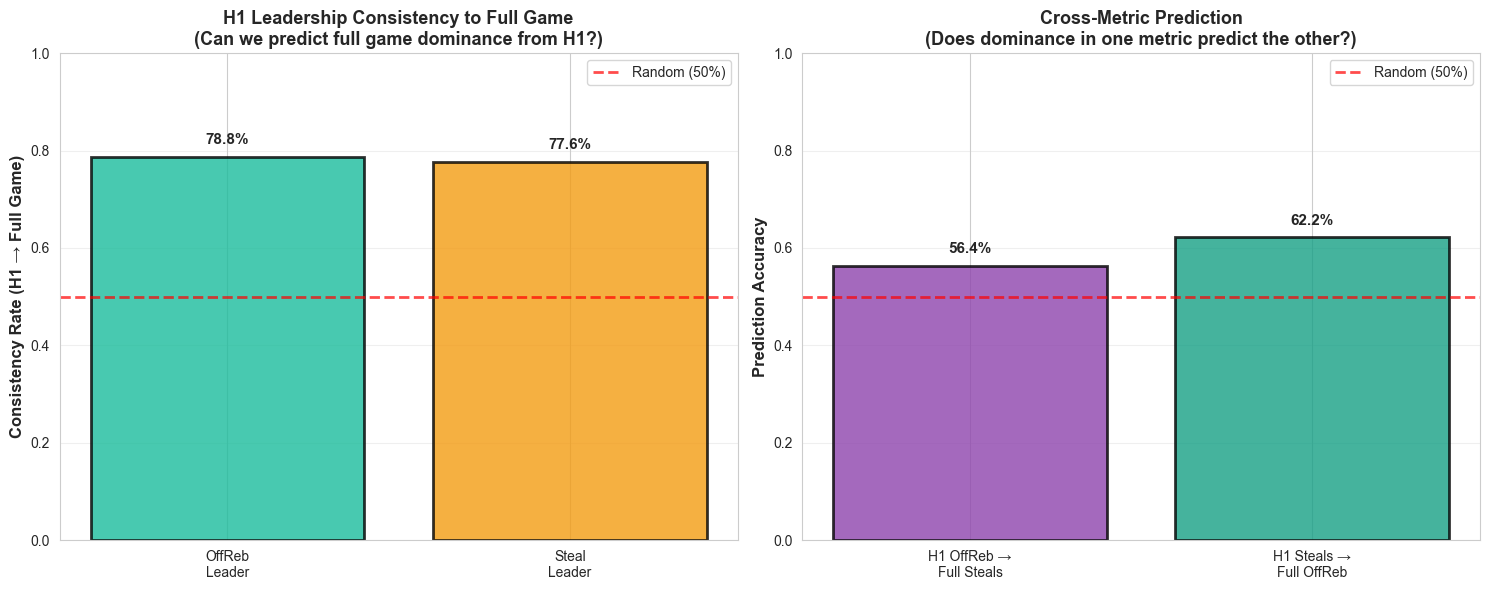

  H1 OffReb Leader → Full Game Steal Winner: 56.37%
  H1 Steal Leader → Full Game OffReb Winner: 62.16%


In [ ]:
# ============================================================================
# PATTERN ANALYSIS 4: Full Game Prediction based on H1 Patterns
# ============================================================================
print("\n" + "=" * 80)
print("PATTERN 4: Predicting Full Game OffReb/Steal Winners from H1")
print("=" * 80)

# Does H1 OffReb leader win the full game OffReb battle?
h1_offreb_predicts_full = (df_games['H1_OffReb_Leader'] == df_games['OffReb_Winner']).mean()
print(f"\nH1 OffReb Leader also wins Full Game OffReb: {h1_offreb_predicts_full:.2%}")

# Does H1 Steal leader win the full game Steal battle?
h1_steal_predicts_full = (df_games['H1_Steal_Leader'] == df_games['Steals_Winner']).mean()
print(f"H1 Steal Leader also wins Full Game Steals: {h1_steal_predicts_full:.2%}")

# Visualization 4
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: Consistency rates
metrics = ['OffReb\nLeader', 'Steal\nLeader']
consistency = [h1_offreb_predicts_full, h1_steal_predicts_full]
colors = ['#1abc9c', '#f39c12']
bars = axes[0].bar(metrics, consistency, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Consistency Rate (H1 → Full Game)', fontsize=12, fontweight='bold')
axes[0].set_title('H1 Leadership Consistency to Full Game\n(Can we predict full game dominance from H1?)', 
                  fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].axhline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Random (50%)')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].legend()
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Chart 2: Cross-metric prediction
# Does H1 OffReb leader also win more steals in full game?
h1_offreb_predicts_steals = (df_games['H1_OffReb_Leader'] == df_games['Steals_Winner']).mean()
# Does H1 Steal leader also win more offrebs in full game?
h1_steal_predicts_offreb = (df_games['H1_Steal_Leader'] == df_games['OffReb_Winner']).mean()

cross_metrics = ['H1 OffReb →\nFull Steals', 'H1 Steals →\nFull OffReb']
cross_values = [h1_offreb_predicts_steals, h1_steal_predicts_offreb]
colors = ['#8e44ad', '#16a085']
bars = axes[1].bar(cross_metrics, cross_values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Prediction Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Cross-Metric Prediction\n(Does dominance in one metric predict the other?)', 
                  fontsize=13, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].axhline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Random (50%)')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('pattern4_h1_to_fullgame.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"  H1 OffReb Leader → Full Game Steal Winner: {h1_offreb_predicts_steals:.2%}")
print(f"  H1 Steal Leader → Full Game OffReb Winner: {h1_steal_predicts_offreb:.2%}")

In [ ]:
# ============================================================================
# PATTERN ANALYSIS 5: Time Series - Momentum Shifts
# ============================================================================
print("\n" + "=" * 80)
print("PATTERN 5: Momentum Analysis (H1 vs H2 Performance)")
print("=" * 80)

# Calculate H2 metrics
df_games['H2_OffReb_Team1'] = df_games['Full_OffReb_Team1'] - df_games['H1_OffReb_Team1']
df_games['H2_OffReb_Team2'] = df_games['Full_OffReb_Team2'] - df_games['H1_OffReb_Team2']
df_games['H2_Steals_Team1'] = df_games['Full_Steals_Team1'] - df_games['H1_Steals_Team1']
df_games['H2_Steals_Team2'] = df_games['Full_Steals_Team2'] - df_games['H1_Steals_Team2']

df_games['H2_OffReb_Diff'] = df_games['H2_OffReb_Team1'] - df_games['H2_OffReb_Team2']
df_games['H2_Steals_Diff'] = df_games['H2_Steals_Team1'] - df_games['H2_Steals_Team2']

# Momentum reversal analysis
df_games['OffReb_Momentum_Shift'] = ((df_games['H1_OffReb_Diff'] > 0) & (df_games['H2_OffReb_Diff'] < 0)) | \
                                     ((df_games['H1_OffReb_Diff'] < 0) & (df_games['H2_OffReb_Diff'] > 0))

df_games['Steal_Momentum_Shift'] = ((df_games['H1_Steals_Diff'] > 0) & (df_games['H2_Steals_Diff'] < 0)) | \
                                    ((df_games['H1_Steals_Diff'] < 0) & (df_games['H2_Steals_Diff'] > 0))

offreb_shift_rate = df_games['OffReb_Momentum_Shift'].mean()
steal_shift_rate = df_games['Steal_Momentum_Shift'].mean()

print(f"\nOffensive Rebound Momentum Shifts (H1→H2): {offreb_shift_rate:.2%}")
print(f"Steal Momentum Shifts (H1→H2): {steal_shift_rate:.2%}")

# When momentum shifts, who wins?
offreb_shift_games = df_games[df_games['OffReb_Momentum_Shift'] == True]
if len(offreb_shift_games) > 0:
    # Who benefits from the shift?
    offreb_shift_beneficiary_wins = (
        ((offreb_shift_games['H1_OffReb_Diff'] < 0) & (offreb_shift_games['Winner'] == 1)) |
        ((offreb_shift_games['H1_OffReb_Diff'] > 0) & (offreb_shift_games['Winner'] == 0))
    ).mean()
    print(f"  → Team that gained OffReb momentum in H2 wins: {offreb_shift_beneficiary_wins:.2%}")

steal_shift_games = df_games[df_games['Steal_Momentum_Shift'] == True]
if len(steal_shift_games) > 0:
    steal_shift_beneficiary_wins = (
        ((steal_shift_games['H1_Steals_Diff'] < 0) & (steal_shift_games['Winner'] == 1)) |
        ((steal_shift_games['H1_Steals_Diff'] > 0) & (steal_shift_games['Winner'] == 0))
    ).mean()
    print(f"  → Team that gained Steal momentum in H2 wins: {steal_shift_beneficiary_wins:.2%}")

# Visualization 5
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Correlation between H1 and H2 metrics
axes[0, 0].scatter(df_games['H1_OffReb_Diff'], df_games['H2_OffReb_Diff'], alpha=0.5, color='#e74c3c')
z = np.polyfit(df_games['H1_OffReb_Diff'], df_games['H2_OffReb_Diff'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df_games['H1_OffReb_Diff'].min(), df_games['H1_OffReb_Diff'].max(), 100)
axes[0, 0].plot(x_trend, p(x_trend), "b--", linewidth=3, label=f'r={df_games["H1_OffReb_Diff"].corr(df_games["H2_OffReb_Diff"]):.3f}')
axes[0, 0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('H1 OffReb Differential', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('H2 OffReb Differential', fontsize=11, fontweight='bold')
axes[0, 0].set_title('OffReb Momentum: H1 → H2\n(Consistency vs Reversal)', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Chart 2: Steal momentum
axes[0, 1].scatter(df_games['H1_Steals_Diff'], df_games['H2_Steals_Diff'], alpha=0.5, color='#3498db')
z = np.polyfit(df_games['H1_Steals_Diff'], df_games['H2_Steals_Diff'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df_games['H1_Steals_Diff'].min(), df_games['H1_Steals_Diff'].max(), 100)
axes[0, 1].plot(x_trend, p(x_trend), "r--", linewidth=3, label=f'r={df_games["H1_Steals_Diff"].corr(df_games["H2_Steals_Diff"]):.3f}')
axes[0, 1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('H1 Steal Differential', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('H2 Steal Differential', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Steal Momentum: H1 → H2\n(Consistency vs Reversal)', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Chart 3: Momentum shift frequency
shift_data = pd.DataFrame({
    'Metric': ['OffReb', 'Steals'],
    'Shift_Rate': [offreb_shift_rate, steal_shift_rate],
    'Consistent_Rate': [1 - offreb_shift_rate, 1 - steal_shift_rate]
})

x = np.arange(len(shift_data))
width = 0.35
bars1 = axes[1, 0].bar(x - width/2, shift_data['Shift_Rate'], width, label='Momentum Shift', color='#e74c3c', alpha=0.8)
bars2 = axes[1, 0].bar(x + width/2, shift_data['Consistent_Rate'], width, label='Consistent', color='#2ecc71', alpha=0.8)
axes[1, 0].set_ylabel('Proportion of Games', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Momentum Shift Frequency', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(shift_data['Metric'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim([0, 1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Chart 4: Average performance by half
h1_avg_offreb = [df_games['H1_OffReb_Team1'].mean(), df_games['H1_OffReb_Team2'].mean()]
h2_avg_offreb = [df_games['H2_OffReb_Team1'].mean(), df_games['H2_OffReb_Team2'].mean()]
h1_avg_steals = [df_games['H1_Steals_Team1'].mean(), df_games['H1_Steals_Team2'].mean()]
h2_avg_steals = [df_games['H2_Steals_Team1'].mean(), df_games['H2_Steals_Team2'].mean()]

x = np.arange(2)
width = 0.2

bars1 = axes[1, 1].bar(x - 1.5*width, h1_avg_offreb, width, label='H1 OffReb', color='#e74c3c', alpha=0.8)
bars2 = axes[1, 1].bar(x - 0.5*width, h2_avg_offreb, width, label='H2 OffReb', color='#c0392b', alpha=0.8)
bars3 = axes[1, 1].bar(x + 0.5*width, h1_avg_steals, width, label='H1 Steals', color='#3498db', alpha=0.8)
bars4 = axes[1, 1].bar(x + 1.5*width, h2_avg_steals, width, label='H2 Steals', color='#2980b9', alpha=0.8)

axes[1, 1].set_ylabel('Average Count', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Average Performance by Half\n(Do teams maintain their intensity?)', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(['Team 1', 'Team 2'])
axes[1, 1].legend(loc='upper right', fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('pattern5_momentum_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PATTERN ANALYSIS 6: Winner Profile Analysis
# ============================================================================
print("\n" + "=" * 80)
print("PATTERN 6: Winner vs Loser Profile Comparison")
print("=" * 80)

# Create winner/loser profiles
winners_profile = {
    'H1_OffReb': df_games[df_games['Winner'] == 1]['H1_OffReb_Team1'].mean(),
    'H1_Steals': df_games[df_games['Winner'] == 1]['H1_Steals_Team1'].mean(),
    'Full_OffReb': df_games[df_games['Winner'] == 1]['Full_OffReb_Team1'].mean(),
    'Full_Steals': df_games[df_games['Winner'] == 1]['Full_Steals_Team1'].mean(),
}

losers_profile = {
    'H1_OffReb': df_games[df_games['Winner'] == 0]['H1_OffReb_Team1'].mean(),
    'H1_Steals': df_games[df_games['Winner'] == 0]['H1_Steals_Team1'].mean(),
    'Full_OffReb': df_games[df_games['Winner'] == 0]['Full_OffReb_Team1'].mean(),
    'Full_Steals': df_games[df_games['Winner'] == 0]['Full_Steals_Team1'].mean(),
}

print("\nWinners Average Profile (Team1 when they win):")
for key, val in winners_profile.items():
    print(f"  {key}: {val:.2f}")

print("\nLosers Average Profile (Team1 when they lose):")
for key, val in losers_profile.items():
    print(f"  {key}: {val:.2f}")

print("\nDifferences (Winners - Losers):")
for key in winners_profile.keys():
    diff = winners_profile[key] - losers_profile[key]
    pct_diff = (diff / losers_profile[key] * 100) if losers_profile[key] != 0 else 0
    print(f"  {key}: {diff:+.2f} ({pct_diff:+.1f}%)")

# Visualization 6
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Radar chart comparison
categories = list(winners_profile.keys())
N = len(categories)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
winners_values = list(winners_profile.values())
losers_values = list(losers_profile.values())

# Close the plot
angles += angles[:1]
winners_values += winners_values[:1]
losers_values += losers_values[:1]

ax = plt.subplot(2, 2, 1, projection='polar')
ax.plot(angles, winners_values, 'o-', linewidth=2, label='Winners', color='#2ecc71')
ax.fill(angles, winners_values, alpha=0.25, color='#2ecc71')
ax.plot(angles, losers_values, 'o-', linewidth=2, label='Losers', color='#e74c3c')
ax.fill(angles, losers_values, alpha=0.25, color='#e74c3c')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_title('Winner vs Loser Profile\n(Radar Chart)', fontsize=13, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

# Chart 2: Side-by-side comparison
x = np.arange(len(categories))
width = 0.35
bars1 = axes[0, 1].bar(x - width/2, list(winners_profile.values()), width, label='Winners', color='#2ecc71', alpha=0.8)
bars2 = axes[0, 1].bar(x + width/2, list(losers_profile.values()), width, label='Losers', color='#e74c3c', alpha=0.8)
axes[0, 1].set_ylabel('Average Count', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Winner vs Loser Metrics\n(Absolute Values)', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(categories, rotation=15, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Chart 3: Percentage differences
diffs = [(winners_profile[k] - losers_profile[k]) / losers_profile[k] * 100 for k in categories]
colors = ['#2ecc71' if d > 0 else '#e74c3c' for d in diffs]
bars = axes[1, 0].barh(categories, diffs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xlabel('Percentage Difference (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Winners vs Losers: % Difference\n(How much better are winners?)', fontsize=13, fontweight='bold')
axes[1, 0].axvline(0, color='black', linewidth=2)
axes[1, 0].grid(True, alpha=0.3, axis='x')

for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[1, 0].text(width + (1 if width > 0 else -1), bar.get_y() + bar.get_height()/2.,
                   f'{width:.1f}%', ha='left' if width > 0 else 'right', va='center', 
                   fontsize=10, fontweight='bold')

# Chart 4: Distribution comparison (box plots)
winner_data = [
    df_games[df_games['Winner'] == 1]['H1_OffReb_Team1'],
    df_games[df_games['Winner'] == 1]['H1_Steals_Team1'],
    df_games[df_games['Winner'] == 1]['Full_OffReb_Team1'],
    df_games[df_games['Winner'] == 1]['Full_Steals_Team1']
]

loser_data = [
    df_games[df_games['Winner'] == 0]['H1_OffReb_Team1'],
    df_games[df_games['Winner'] == 0]['H1_Steals_Team1'],
    df_games[df_games['Winner'] == 0]['Full_OffReb_Team1'],
    df_games[df_games['Winner'] == 0]['Full_Steals_Team1']
]

positions = np.arange(1, len(categories) * 2 + 1, 2)
bp1 = axes[1, 1].boxplot(winner_data, positions=positions - 0.3, widths=0.5, patch_artist=True,
                          boxprops=dict(facecolor='#2ecc71', alpha=0.7),
                          medianprops=dict(color='darkgreen', linewidth=2),
                          whiskerprops=dict(color='green'),
                          capprops=dict(color='green'))
bp2 = axes[1, 1].boxplot(loser_data, positions=positions + 0.3, widths=0.5, patch_artist=True,
                          boxprops=dict(facecolor='#e74c3c', alpha=0.7),
                          medianprops=dict(color='darkred', linewidth=2),
                          whiskerprops=dict(color='red'),
                          capprops=dict(color='red'))

axes[1, 1].set_xticks(positions)
axes[1, 1].set_xticklabels(categories, rotation=15, ha='right')
axes[1, 1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Distribution Comparison\n(Winners vs Losers)', fontsize=13, fontweight='bold')
axes[1, 1].legend([bp1["boxes"][0], bp2["boxes"][0]], ['Winners', 'Losers'], loc='upper right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('pattern6_winner_profiles.png', dpi=300, bbox_inches='tight')
plt.show()


PATTERN 5: Momentum Analysis (H1 vs H2 Performance)


NameError: name 'df_games' is not defined

In [ ]:
# ============================================================================
# FINAL SUMMARY: KEY FINDINGS
# ============================================================================
print("\n" + "=" * 80)
print("KEY FINDINGS SUMMARY")
print("=" * 80)

print("\n1. H1 OFFENSIVE REBOUND IMPACT:")
print(f"   → H1 OffReb leader wins game: {offreb_leader_win_rate:.1%}")
print(f"   → Statistical significance: {'YES' if p_value < 0.05 else 'NO'}")

print("\n2. H1 STEAL IMPACT:")
print(f"   → H1 Steal leader wins game: {steal_leader_win_rate:.1%}")

print("\n3. COMBINED DOMINANCE:")
print(f"   → Leading in BOTH metrics (H1): {both_leader_wr:.1%} win rate")
print(f"   → Leading in NEITHER metric (H1): {neither_leader_wr:.1%} win rate")

print("\n4. PREDICTIVE POWER (AUC):")
print(f"   → H1 OffReb alone: {auc_offreb:.3f}")
print(f"   → H1 Steals alone: {auc_steals:.3f}")
print(f"   → Both combined: {auc_both:.3f}")
print(f"   → Best predictor: {'Combined' if auc_both == max(auc_offreb, auc_steals, auc_both) else 'OffReb' if auc_offreb > auc_steals else 'Steals'}")

print("\n5. CONSISTENCY (H1 → Full Game):")
print(f"   → H1 OffReb leader maintains lead: {h1_offreb_predicts_full:.1%}")
print(f"   → H1 Steal leader maintains lead: {h1_steal_predicts_full:.1%}")

print("\n6. MOMENTUM SHIFTS:")
print(f"   → OffReb momentum shifts H1→H2: {offreb_shift_rate:.1%}")
print(f"   → Steal momentum shifts H1→H2: {steal_shift_rate:.1%}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print("\nGenerated Visualizations:")
print("  1. pattern1_offreb_leader_wins.png")
print("  2. pattern2_steal_leader_wins.png")
print("  3. pattern3_combined_metrics.png")
print("  4. pattern4_h1_to_fullgame.png")
print("  5. pattern5_momentum_analysis.png")
print("  6. pattern6_winner_profiles.png")
print("\nAll patterns based on 2020-2021 season data!")
print("=" * 80)


KEY FINDINGS SUMMARY

1. H1 OFFENSIVE REBOUND IMPACT:
   → H1 OffReb leader wins game: 50.2%
   → Statistical significance: NO

2. H1 STEAL IMPACT:
   → H1 Steal leader wins game: 49.8%

3. COMBINED DOMINANCE:
   → Leading in BOTH metrics (H1): 65.4% win rate
   → Leading in NEITHER metric (H1): 58.0% win rate

4. PREDICTIVE POWER (AUC):
   → H1 OffReb alone: 0.514
   → H1 Steals alone: 0.516
   → Both combined: 0.515
   → Best predictor: Steals

5. CONSISTENCY (H1 → Full Game):
   → H1 OffReb leader maintains lead: 78.8%
   → H1 Steal leader maintains lead: 77.6%

6. MOMENTUM SHIFTS:
   → OffReb momentum shifts H1→H2: 36.7%
   → Steal momentum shifts H1→H2: 37.1%

ANALYSIS COMPLETE!

Generated Visualizations:
  1. pattern1_offreb_leader_wins.png
  2. pattern2_steal_leader_wins.png
  3. pattern3_combined_metrics.png
  4. pattern4_h1_to_fullgame.png
  5. pattern5_momentum_analysis.png
  6. pattern6_winner_profiles.png

All patterns based on 2020-2021 season data!
